## _Napredna eksplorativna analiza i inženjering podataka_ 
#### Sadrzaj:

#### 1. __Eksplorativna analiza podataka__ - opis varijabli, num/cat kolone, analiza duplikata i missing vrednosti

#### 2. __Data Engineering__ - feature/target analiza odnosa, medjuzavisnost varijabli

#### 3. __Modeliranje i optimizacija hiperparametara__ - Izbor modela, cross-validation, optimizacija hiperparametara i finalni model

#### 4. __Evaluacija__ - analiza dobijenih rezultata

#### 5. __Interpretabilnost modela__ - feature importances, coef_

#### 6. __Diskusija__

#### 7. __Zakljucak__

(Luka Jašović, 2025430016)

---

## __EDA__ - kratak opis varijabli iz dataseta

Chromosome - hromozom na kome se nalazi genomska varijanta (varijante tp53 gena se nalaze na hromozomu br. 17)

Start - pocetna genomska pozicija 

ReferenceAlleleVCF - Referentni alel (varijanta gena) iz VCF zapisa

AlternateAlleleVCF - Alternativni alel koji predstavlja mutaciju u odnosnu na referentni gen

GeneSymbol - Naziv gena 

ClinSigSimple (target) - binarna klinicka klasifikacija varijante:

 - 0 benigna

 - 1 patogena

cadd_raw - output skor direktno iz modela, pokazuje stetnost varijante

cadd_phred - kvantifikacija potencijalne stetnosti varijante u odnosu na sve moguce mutacije. Veca vrednost = verovatno veca patogenost

revel - ensebml skor dizajniran za procenu patogenosti `missense` varijanti. U rasponu od 0-1, veca vrednost ukazuje na vecu patogenost

sift_score - Prediktivni skor baziran na evolutivnoj konzervaciji aminokiselina. Niže vrednosti ukazuju na veći negativni efekat mutacije

blosum62 - skor koji prikazuje stepen zamene aminokiseline u proteinu

alphamissense_score - deep learning skor razvijen od strane alphamissense modela, specifican za missense varijante i procenjuje verovatnocu patogenosti

impact - kategorijska promenljiva, koja opisuje funkcionalni uticaj varijante na funkcionalni protein:

- LOW
- HIGH
- MODERATE
- MODIFIER

consequence - nominalna kategorijska promenljiva. Molekularna posledica varijante na tranksript. Predstavlja tip strukturne promene izazvane datom varijantom



---

In [1]:
#bilbioteke

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

## **EDA 1** - Ispitivanje strukture, kvaliteta i sadrzaja dataseta

### Kompletan sirovi dataframe 

In [2]:
import os
print(os.getcwd())

c:\Users\Admin\ML


In [3]:
complete_dataset = pd.read_csv(os.path.join(os.getcwd(),'dataset_raw.csv'),index_col=0)

In [4]:
#Dropujem sve duplikate varijanti (17)
complete_dataset['variant_id'] = complete_dataset['variant_id'].drop_duplicates()

In [5]:
# variant_id, vcf_format informativne kolone, bile su neophodne samo za preuzimanje anotacija
complete_dataset.drop(columns={'variant_id','vcf_format'},inplace=True)

### EDA 1.1 - Struktura 

In [6]:
complete_dataset.head()

,Chromosome,Start,ReferenceAlleleVCF,AlternateAlleleVCF,GeneSymbol,ClinSigSimple,cadd_phred,cadd_raw,revel,sift_score,blosum62,alphamissense_score,impact,consequence
0,17.0,7674221.0,G,A,TP53,1.0,29.20,5.203168,0.927,0.00,-3.0,0.9968,MODERATE,missense_variant
1,17.0,7674191.0,C,T,TP53,1.0,25.30,4.453018,0.961,0.00,1.0,0.9918,MODERATE,missense_variant
2,17.0,7674230.0,C,A,TP53,1.0,27.50,4.936062,0.970,0.00,-3.0,0.9965,MODERATE,missense_variant
3,17.0,7674208.0,A,G,TP53,1.0,24.90,4.298395,0.952,0.00,-3.0,0.9967,MODERATE,missense_variant
4,17.0,7676154.0,G,C,TP53,1.0,12.91,1.299883,0.368,0.14,-2.0,0.0724,MODERATE,missense_variant


In [7]:
complete_dataset.dtypes

Chromosome             float64
Start                  float64
ReferenceAlleleVCF      object
AlternateAlleleVCF      object
GeneSymbol              object
ClinSigSimple          float64
cadd_phred             float64
cadd_raw               float64
revel                  float64
sift_score             float64
blosum62               float64
alphamissense_score    float64
impact                  object
consequence             object
dtype: object

### EDA 1.2 Kategorijske vrednosti

In [8]:
complete_dataset.select_dtypes(exclude='number').head()

,ReferenceAlleleVCF,AlternateAlleleVCF,GeneSymbol,impact,consequence
0,G,A,TP53,MODERATE,missense_variant
1,C,T,TP53,MODERATE,missense_variant
2,C,A,TP53,MODERATE,missense_variant
3,A,G,TP53,MODERATE,missense_variant
4,G,C,TP53,MODERATE,missense_variant


##### __impact__

##### __consequence__

- 2 kategorisjske vrednosti iz informativnog dela dataseta

In [9]:
complete_dataset['impact'].value_counts()

impact
MODERATE    1383
LOW          721
MODIFIER     363
HIGH         179
Name: count, dtype: int64

MODIFIER < LOW < MODERATE < HIGH 

Objasnjava uticaj koji varijanta ima kod svog nosioca, na njegovo fizicko zdravlje. Pokazatelj ispoljavanja patogenosti. 

__impact__ predstavlja ordinalnu kategorijsku varijablu

- Primenicu ordinalno enkodiranje kasnije


In [10]:
# consequence
# Kandidat za OneHotEncoder
complete_dataset['consequence'].value_counts()

consequence
missense_variant                       1383
synonymous_variant                      462
intron_variant                          287
splice_region_variant                   120
splice_polypyrimidine_tract_variant      89
stop_gained                              89
splice_donor_variant                     44
3_prime_UTR_variant                      39
splice_acceptor_variant                  39
splice_donor_region_variant              31
downstream_gene_variant                  21
splice_donor_5th_base_variant            19
5_prime_UTR_variant                      16
stop_lost                                 7
Name: count, dtype: int64

In [11]:
X_categoric = complete_dataset[['impact','consequence']]

#### EDA 1.3 Numericke vrednosti

In [12]:
complete_dataset.select_dtypes(include='number')

,Chromosome,Start,ClinSigSimple,cadd_phred,cadd_raw,revel,sift_score,blosum62,alphamissense_score
0,17.0,7674221.0,1.0,29.200,5.203168,0.927,0.00,-3.0,0.9968
1,17.0,7674191.0,1.0,25.300,4.453018,0.961,0.00,1.0,0.9918
2,17.0,7674230.0,1.0,27.500,4.936062,0.970,0.00,-3.0,0.9965
3,17.0,7674208.0,1.0,24.900,4.298395,0.952,0.00,-3.0,0.9967
4,17.0,7676154.0,1.0,12.910,1.299883,0.368,0.14,-2.0,0.0724
...,...,...,...,...,...,...,...,...,...
2414,NaN,NaN,NaN,22.800,3.527470,0.741,0.00,-2.0,0.7138
2418,NaN,NaN,NaN,22.400,3.408435,0.454,0.18,-3.0,0.2035
2419,NaN,NaN,NaN,2.676,0.242317,NaN,NaN,NaN,NaN
2523,NaN,NaN,NaN,0.519,-0.183705,NaN,NaN,NaN,NaN


Prikaz jednistvenih vrednosti numerickih feature-a:

<Axes: title={'center': 'Numericke varijable sa jedinstvenim vrednostima'}>

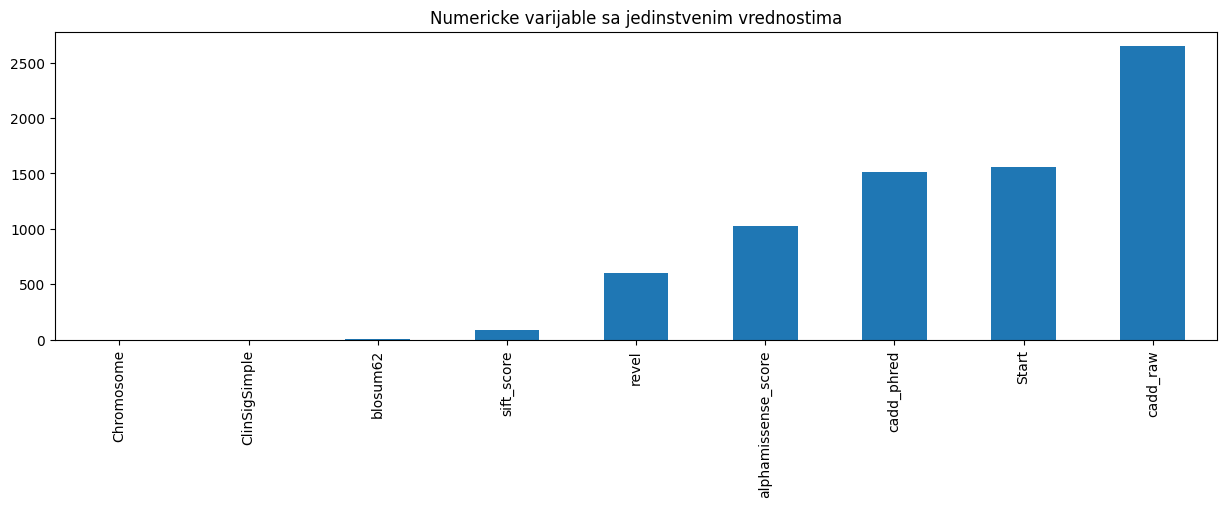

In [13]:
unique = complete_dataset.select_dtypes(include='number').nunique().sort_values()
unique.plot.bar(figsize=(15,4),title='Numericke varijable sa jedinstvenim vrednostima')

#### Ispitivanje `missing` vrednosti

In [14]:
for col in complete_dataset.columns:
    print(f'{col}: {complete_dataset[col].isna().sum()} missing values ')

Chromosome: 16 missing values 
Start: 16 missing values 
ReferenceAlleleVCF: 16 missing values 
AlternateAlleleVCF: 16 missing values 
GeneSymbol: 16 missing values 
ClinSigSimple: 16 missing values 
cadd_phred: 17 missing values 
cadd_raw: 17 missing values 
revel: 1280 missing values 
sift_score: 1280 missing values 
blosum62: 1280 missing values 
alphamissense_score: 1280 missing values 
impact: 17 missing values 
consequence: 17 missing values 


In [15]:
#procenat missing vrednosti po koloni
#method-chain

(complete_dataset.isna()
.sum()
.reset_index()
.rename(columns={'index':'feature',0:'bez_vrednosti'})
.sort_values('bez_vrednosti',ascending=False)
.assign(procenat_bez_vrednosti = lambda x: x['bez_vrednosti'] / len(complete_dataset) * 100).round(2))


,feature,bez_vrednosti,procenat_bez_vrednosti
8,revel,1280,48.07
9,sift_score,1280,48.07
10,blosum62,1280,48.07
11,alphamissense_score,1280,48.07
7,cadd_raw,17,0.64
6,cadd_phred,17,0.64
12,impact,17,0.64
13,consequence,17,0.64
5,ClinSigSimple,16,0.60
4,GeneSymbol,16,0.60


Veliki procenat nedostajucih vrednosti kod REVEL, SIFT, BLOSUM62 i AlphaMissense score-ova je posledica bioloskog konteksta. Ovi prediktori

se racunaju iskljucivo za `missense_variant` tip varijanti u protein-kodirajucim regionima. 

Iz tog razloga, nedostajuce vrednosti zadrzavam kao informativne

Navedenu tvrdju testiram uz pomoc crosstab nad missing vrednostima iz ovih feature-a sa tipovima varijanti.

In [16]:
pd.crosstab(complete_dataset['consequence'],complete_dataset['blosum62'].isna())

blosum62,False,True
consequence,,
3_prime_UTR_variant,0,39
5_prime_UTR_variant,0,16
downstream_gene_variant,0,21
intron_variant,0,287
missense_variant,1383,0
splice_acceptor_variant,0,39
splice_donor_5th_base_variant,0,19
splice_donor_region_variant,0,31
splice_donor_variant,0,44


In [17]:
pd.crosstab(complete_dataset['consequence'],complete_dataset['alphamissense_score'].isna())

alphamissense_score,False,True
consequence,,
3_prime_UTR_variant,0,39
5_prime_UTR_variant,0,16
downstream_gene_variant,0,21
intron_variant,0,287
missense_variant,1383,0
splice_acceptor_variant,0,39
splice_donor_5th_base_variant,0,19
splice_donor_region_variant,0,31
splice_donor_variant,0,44


In [18]:
pd.crosstab(complete_dataset['consequence'],complete_dataset['sift_score'].isna())

sift_score,False,True
consequence,,
3_prime_UTR_variant,0,39
5_prime_UTR_variant,0,16
downstream_gene_variant,0,21
intron_variant,0,287
missense_variant,1383,0
splice_acceptor_variant,0,39
splice_donor_5th_base_variant,0,19
splice_donor_region_variant,0,31
splice_donor_variant,0,44


In [19]:
pd.crosstab(complete_dataset['consequence'],complete_dataset['revel'].isna())

revel,False,True
consequence,,
3_prime_UTR_variant,0,39
5_prime_UTR_variant,0,16
downstream_gene_variant,0,21
intron_variant,0,287
missense_variant,1383,0
splice_acceptor_variant,0,39
splice_donor_5th_base_variant,0,19
splice_donor_region_variant,0,31
splice_donor_variant,0,44


In [20]:
pd.crosstab(complete_dataset['consequence'],complete_dataset['revel'].isna())

revel,False,True
consequence,,
3_prime_UTR_variant,0,39
5_prime_UTR_variant,0,16
downstream_gene_variant,0,21
intron_variant,0,287
missense_variant,1383,0
splice_acceptor_variant,0,39
splice_donor_5th_base_variant,0,19
splice_donor_region_variant,0,31
splice_donor_variant,0,44


Vrednosti koje nedostaju su u potpnosti asocirane sa tipom molekularne posledice varijante, sto potvrdjuje da ove vrednosti koje nedostaju nisu 

slucajnost vec bioloska karakteristika. Samo `missense_variant` podkategorija sadrzi vrednosti, dok sve ostale nemaju vrednosti ovih score-ova.

### Missing vrednosti se ovde klasifikuju u **MNAR** (Missing not at random)

Text(0, 0.5, '%')

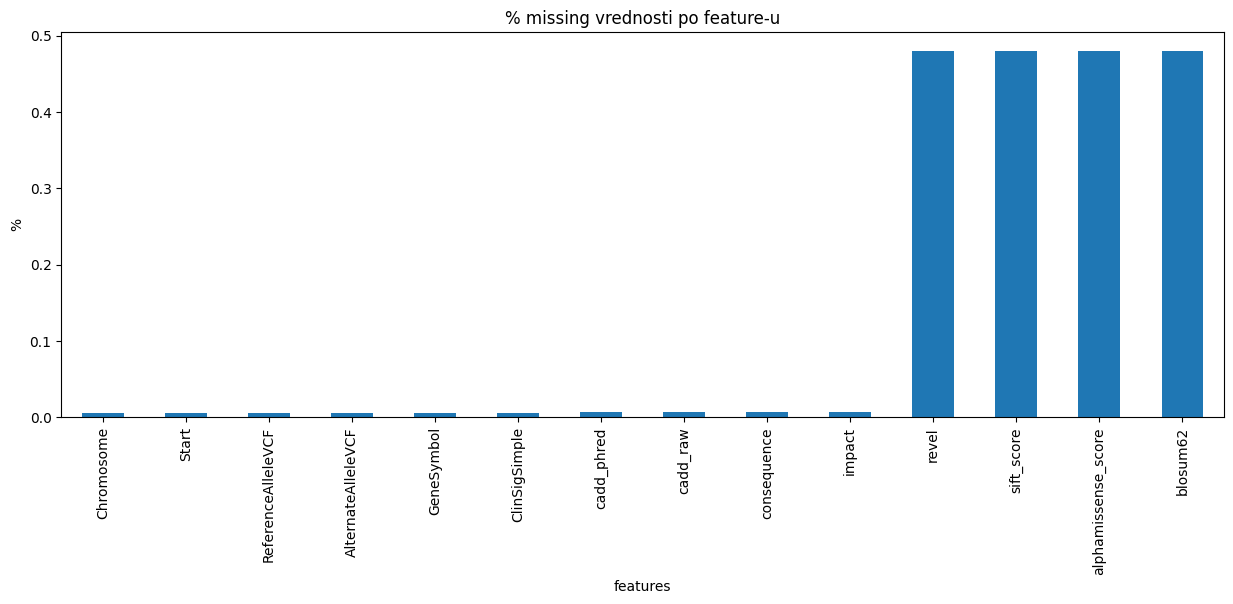

In [21]:
#vizuelizacija missing vrednosti po feature-u:
complete_dataset.isna().mean().sort_values().plot.bar(figsize=(15,5),title='% missing vrednosti po feature-u')
plt.xlabel('features')
plt.ylabel('%')

In [22]:
complete_dataset['consequence'].value_counts()

consequence
missense_variant                       1383
synonymous_variant                      462
intron_variant                          287
splice_region_variant                   120
splice_polypyrimidine_tract_variant      89
stop_gained                              89
splice_donor_variant                     44
3_prime_UTR_variant                      39
splice_acceptor_variant                  39
splice_donor_region_variant              31
downstream_gene_variant                  21
splice_donor_5th_base_variant            19
5_prime_UTR_variant                      16
stop_lost                                 7
Name: count, dtype: int64

##### Dropujem sledece missing vrednosti koje su nastale prilikom preuzimanja orignalnog dataseta:

Chromosome: 16 missing values

Start: 16 missing values 

ReferenceAlleleVCF: 16 missing values 

AlternateAlleleVCF: 16 missing values 

GeneSymbol: 16 missing values

ClinSigSimple: 16 missing values 

In [23]:
subset = ['Chromosome','Start','ReferenceAlleleVCF','AlternateAlleleVCF','GeneSymbol','ClinSigSimple']
complete_dataset.dropna(subset=subset,inplace=True)
complete_dataset.shape

(2647, 14)

Duplikati

In [24]:
complete_dataset.duplicated().any()

np.False_

Numericke kolone

In [25]:
complete_dataset.select_dtypes(include='number')
X_numeric = complete_dataset.select_dtypes(include='number').iloc[:,2:]
X_numeric.drop(columns={'ClinSigSimple'},inplace=True)

In [26]:
# set informativnih numerickih feature-a
X_numeric.head()

,cadd_phred,cadd_raw,revel,sift_score,blosum62,alphamissense_score
0,29.20,5.203168,0.927,0.00,-3.0,0.9968
1,25.30,4.453018,0.961,0.00,1.0,0.9918
2,27.50,4.936062,0.970,0.00,-3.0,0.9965
3,24.90,4.298395,0.952,0.00,-3.0,0.9967
4,12.91,1.299883,0.368,0.14,-2.0,0.0724


In [27]:
X_numeric.columns

Index(['cadd_phred', 'cadd_raw', 'revel', 'sift_score', 'blosum62',
       'alphamissense_score'],
      dtype='object')

## **Data Engineering** 
#### Feature/Target analiza odnosa (Numericke kolone). Analiza uticaja pojedinacnih feature-a sa target feature-om. 

- boxplot/violinplot

- histplot

- kde plot 

- zakljucak za svaki pojednacni feature

### 1. __cadd_phred__

In [28]:
complete_dataset.groupby('ClinSigSimple')['cadd_phred'].describe()

,count,mean,std,min,25%,50%,75%,max
ClinSigSimple,,,,,,,,
0.0,2013.0,13.564331,10.115576,0.001,4.912,11.66,22.7,52.0
1.0,617.0,21.252334,9.876733,0.003,16.700,24.60,26.8,48.0


Patogene varijante  (1) - znacajno vise prosecne i medijalne `cadd_phred` skorove, sto je u skladu sa bioloskim ocekivanjima, jer `CADD` meri 

verovatnocu funkcionalnog ostecenje varijante.

### min 

- min vrednosti slicne u obe grupe, sto znaci da postoje varijante sa niskim CADD skorom u obe klase

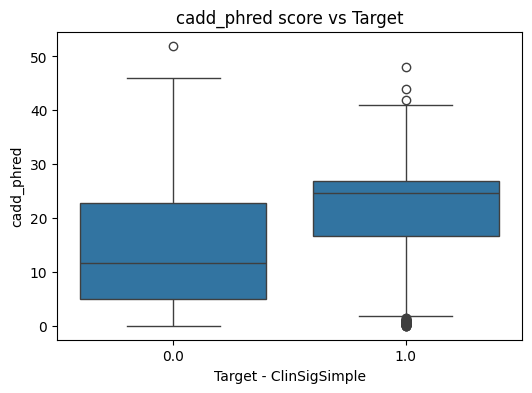

In [29]:
plt.figure(figsize=(6,4))
sns.boxplot(data=complete_dataset,x='ClinSigSimple',y='cadd_phred')
plt.title('cadd_phred score vs Target')
plt.xlabel('Target - ClinSigSimple')
plt.ylabel('cadd_phred')
plt.show()

Klasa 1 (pathogenic) - dominira visim vrednostima cadd_phred score-a

<Axes: xlabel='cadd_phred', ylabel='Count'>

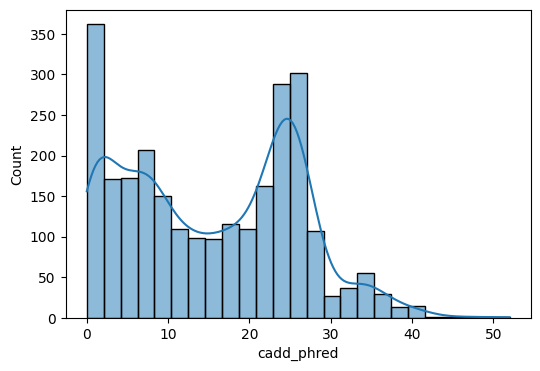

In [30]:
plt.figure(figsize=(6,4))
sns.histplot(data=X_numeric,x=X_numeric['cadd_phred'],bins=25,kde=True)

Bimodalni histogram, 2 pika koja predstavljaju vrednosti koje pripadaju klasi 0 i klasi 1

- prvi pik odgovarai klasi 0 

- drugi pik odgovara klasi 1

<Axes: xlabel='cadd_phred', ylabel='Density'>

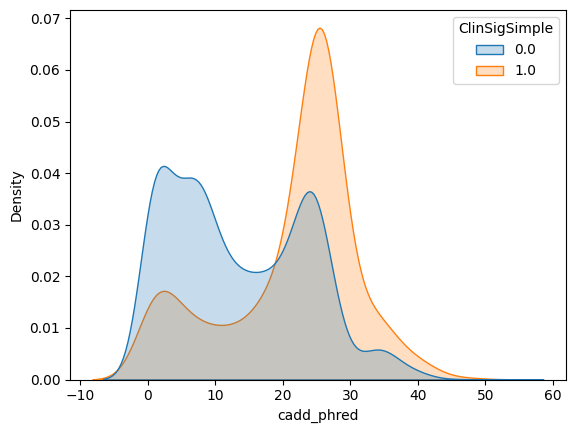

In [31]:
sns.kdeplot(data=complete_dataset,x='cadd_phred',hue='ClinSigSimple',common_norm=False,fill=True)

Kernel Density Estimation plot: 

Distribucija cadd_phred u okviru klasa.KDE pokazuje pomeranje distribucije `cadd_phred` ka visim vrednostima za pozitivnu klasu (`ClinSigSimple` 

= 1 ), uz delimicno preklapanje distribucija, pogotovo u srednjem opsegu.

Na osnovu boxplot,histogram i KDE analiza, `cadd_phred` pokazuje solidnu diskriminativnu vrednost izmedju klasa, sa visim vrednostima dominantno prisutnim u pozitivnoj klasi (label 1) sto ga cini dobrnim kandidatom za dalje modelovanje

### 2. **cadd_raw**

In [32]:
complete_dataset.groupby('ClinSigSimple')['cadd_raw'].describe()

,count,mean,std,min,25%,50%,75%,max
ClinSigSimple,,,,,,,,
0.0,2013.0,1.949516,2.016300,-2.128301,0.447679,1.132460,3.496207,11.296629
1.0,617.0,3.562425,2.143742,-1.709595,1.988629,4.201465,4.797977,10.627289


Za patogene varijante (`ClinSigSimple` = 1), prosecne vrednosti cadd_raw score-a su znatno vise, sto je u skladu s bioloskim podacima i 

kontekstom za ovaj score. On pokazuje odstupanje od varijante u normalnom ( zdravom ) genomu, te visi score pokazuje veci stepen moguce 

patogenosti.


MAX vrednosti - Iako se maksimalne vrednosti delimično preklapaju između klasa, ekstremne vrednosti u benignoj klasi predstavljaju pojedinačne

outlier-e, s obzirom da su centralne tendencije (25%, 50%, 75%) jasno niže u odnosu na patogenu klasu.

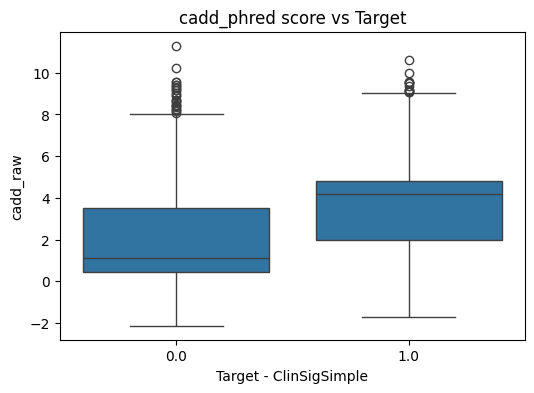

In [33]:
plt.figure(figsize=(6,4))
sns.boxplot(data=complete_dataset,x='ClinSigSimple',y='cadd_raw')
plt.title('cadd_phred score vs Target')
plt.xlabel('Target - ClinSigSimple')
plt.ylabel('cadd_raw')
plt.show()

<Axes: xlabel='ClinSigSimple', ylabel='cadd_raw'>

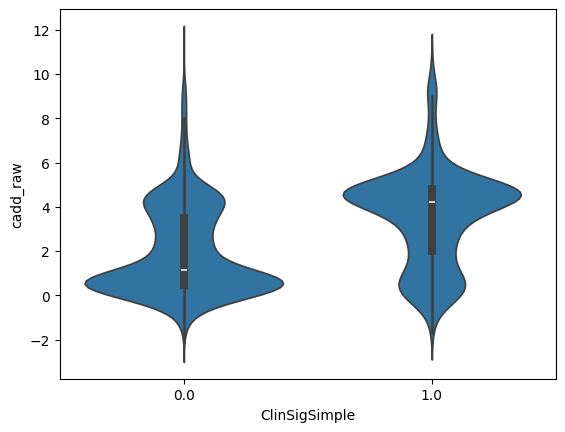

In [34]:
sns.violinplot(data=complete_dataset,x='ClinSigSimple',y='cadd_raw')

<Axes: xlabel='cadd_raw', ylabel='Count'>

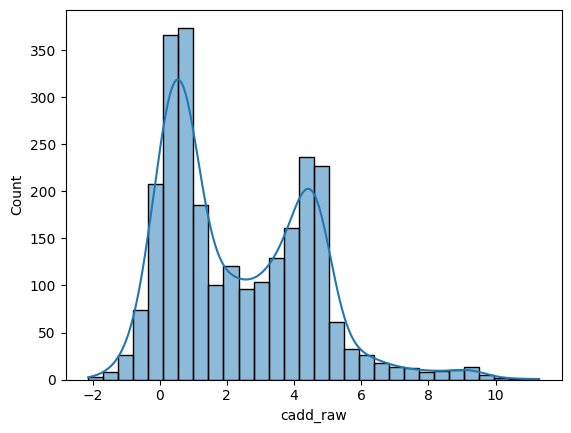

In [35]:
sns.histplot(data=complete_dataset,x='cadd_raw',bins=30,kde=True)

Distribucija `cadd_raw` ima bimodalnu strukturu, dva izrazena pika. Prisutnost izrazenog desnog repa ( `right-skewed distribucija`) sugerise da 

jako mali broj varijanti ima visoke vrednosti score-ova, koje potencijalno predstavljaju varijante sa izrazenim efektomm. 

Vecina zapazenih varijanti koncetrisana je u nizem i srednjem opsegu vrednosti dok su ekstremno visoke vrednosti retke i mogu se posmatrati kao

outlier-i u kontekstu celokupne distribucije.

In [36]:
q25 = np.quantile(X_numeric['cadd_raw'].dropna(),q=0.25)
q75 = np.quantile(X_numeric['cadd_raw'].dropna(),q=.75)
iqr = q75 - q25

In [37]:
donja_granica = q25 - iqr*1.5
gornja_granica = q75 + iqr*1.5
outlieri = X_numeric['cadd_raw'][(X_numeric['cadd_raw']>gornja_granica)|(X_numeric['cadd_raw']<donja_granica)]
outlieri

939     11.296629
1216     9.993170
1220    10.627289
1714    10.205599
Name: cadd_raw, dtype: float64

In [38]:
# Proveravam klase outlier varijanti:

outlier_idx = [939,1215,1220,1714]
complete_dataset.loc[outlier_idx,['ClinSigSimple']]

# Zadrzavam ove ekstremne vrednosti u analizi jer mogu predstavljati bioloski relevantne slucajeve sa povecanom patogenoscu

,ClinSigSimple
939,0.0
1215,1.0
1220,1.0
1714,0.0


<Axes: xlabel='cadd_raw', ylabel='Density'>

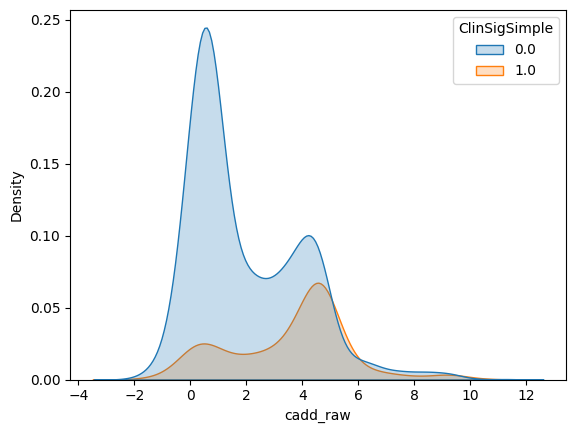

In [39]:
sns.kdeplot(data=complete_dataset,x='cadd_raw',hue='ClinSigSimple',fill=True)

Distribucija vrednosti cadd_raw score-a. Desno asimetricna tj. right-skewed za obe klase.

Za klasu 0 vecina distribucije je u nizem i srednjem opsegu, a distribucija vrednosti za klasu 1 je pomerena u desno, sa vecom gustinom i 

srednjim i visim vrednostima.

Preklapanje klasa:

Znacajno preklapanje distribucije klasa po srednjem opsegu. To implicira da `cadd_raw` sam po sebi nije dovoljan za savrsenu separaciju klasa 

ali jeste diskriminitivan.

### 3. **revel**

In [40]:
complete_dataset.groupby('ClinSigSimple')['revel'].describe()

,count,mean,std,min,25%,50%,75%,max
ClinSigSimple,,,,,,,,
0.0,942.0,0.603864,0.231518,0.104,0.39925,0.5785,0.83575,0.977
1.0,434.0,0.775541,0.212130,0.138,0.63725,0.8785,0.93500,0.982


Za revel score, centralne tendencije su vise za pozitivnu klasu (1)

<Axes: xlabel='ClinSigSimple', ylabel='revel'>

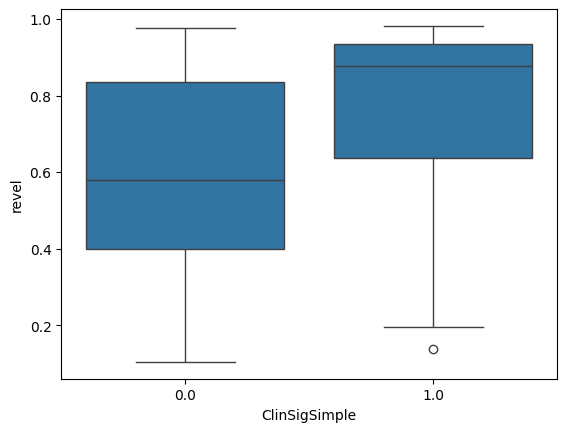

In [41]:
sns.boxplot(data=complete_dataset,x='ClinSigSimple',y='revel')

<Axes: xlabel='revel', ylabel='Density'>

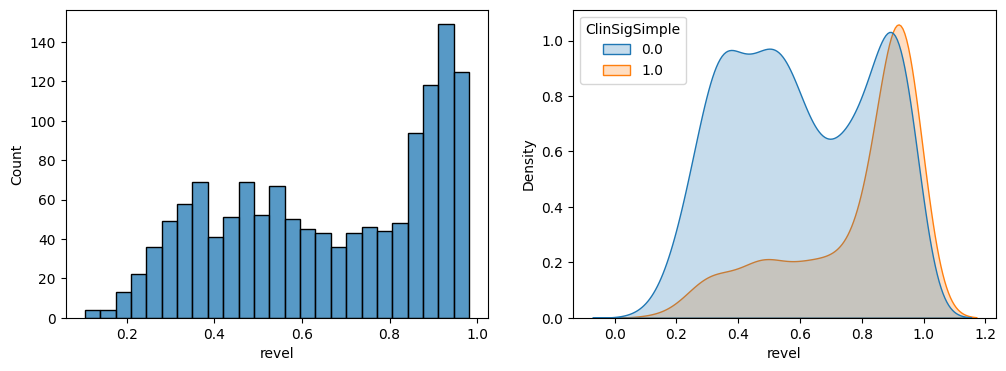

In [42]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 4))
sns.histplot(data=complete_dataset,x='revel',bins=25,ax=ax[0])
sns.kdeplot(data=complete_dataset,hue='ClinSigSimple',x='revel',fill=True)



Distribucija vrednosti je asimetricna na levo. KDE plot pokazuje distribuciju revel score-a koja se preklapa izmedju dve klase, pri cemu je

gustina distribucije veca u srednjem delu i visem delu za klasu 0 , dok je gustina distribucije veca u visem delu za klasu 1.

### 4. **Sift_score**

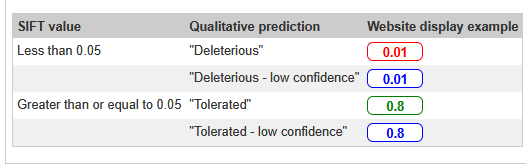

`sift_score` 

- <0.05 - `Deleterious` (stetan efekat)

- .>=0.05 - `Tolerated` (tolerisan, veće vrednosti, vise 'neutralan' efekat)

In [43]:
complete_dataset['sift_score'].value_counts()

sift_score
0.00    570
0.01    102
0.02     70
0.03     50
0.04     34
       ... 
0.67      1
0.88      1
0.89      1
0.53      1
0.43      1
Name: count, Length: 89, dtype: int64

In [44]:
complete_dataset.groupby('ClinSigSimple')['sift_score'].describe()

,count,mean,std,min,25%,50%,75%,max
ClinSigSimple,,,,,,,,
0.0,942.0,0.153896,0.233987,0.0,0.0,0.04,0.21,1.0
1.0,434.0,0.064355,0.151162,0.0,0.0,0.00,0.04,1.0


<Axes: xlabel='ClinSigSimple', ylabel='sift_score'>

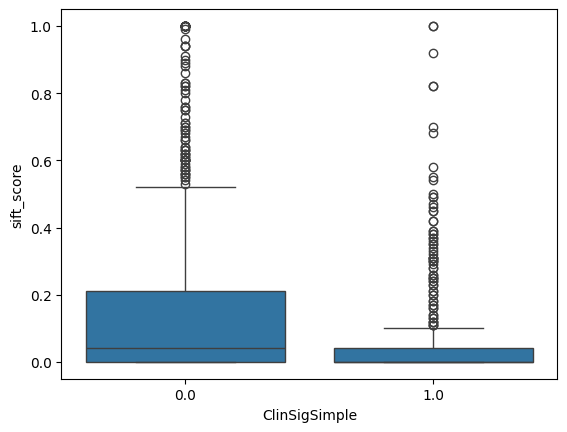

In [45]:
sns.boxplot(data=complete_dataset,x='ClinSigSimple',y='sift_score')

Text(0.01, 850, '0.05 threshold')

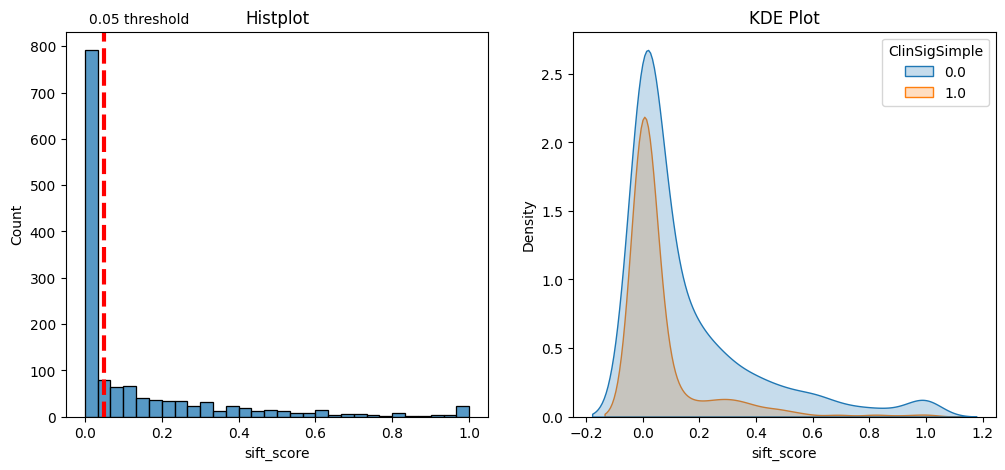

In [46]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.histplot(data=complete_dataset,x='sift_score',bins=30,ax=ax[0])
sns.kdeplot(data=complete_dataset,x='sift_score',fill=True,hue='ClinSigSimple',ax=ax[1])
ax[0].set_label('0.05 threshold')
ax[0].set_title('Histplot')
ax[1].set_title('KDE Plot')
ax[0].axvline(x=0.05,color='red',linestyle='--',linewidth=3)
ax[0].text(x=0.01,y=850,s='0.05 threshold')
#ax[0].axvline(x=)

Boxplot i KDE plot analiza pokazuju da za klasu 1 (patogena klasa) ima najveci broj vrednosti koji su blizu 0, sto je u korelaciji sa bioloskim

podacima, sa obzirom na to da <0.05 zaista prikazuje patogenost. Dok za klasu 0, veliki broj vrednosti se nalazi oko 0, ali i u srednjem i visem 

opsegu. Ove ekstremne vrednosti koje su deo desnog repa nisu outileri, vec bioloski znacajne vrednosti za ovaj score.

### 5. **Blosum62**

- patogene varijante: nizi score


In [47]:
complete_dataset.groupby('ClinSigSimple')['blosum62'].describe()

,count,mean,std,min,25%,50%,75%,max
ClinSigSimple,,,,,,,,
0.0,942.0,-0.628450,1.514351,-3.0,-2.0,-1.0,1.0,3.0
1.0,434.0,-0.967742,1.537483,-3.0,-2.0,-1.0,0.0,3.0


<Axes: xlabel='ClinSigSimple', ylabel='blosum62'>

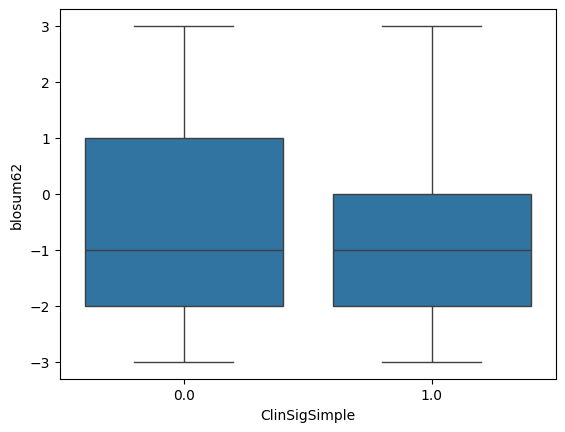

In [48]:
sns.boxplot(complete_dataset,x='ClinSigSimple',y='blosum62')

<Axes: xlabel='blosum62', ylabel='Count'>

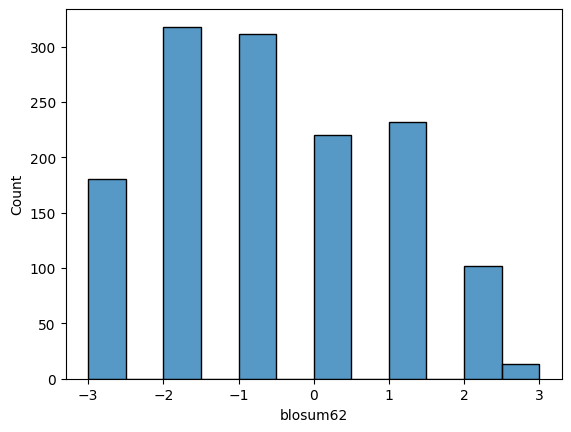

In [49]:
sns.histplot(complete_dataset,x='blosum62')

<Axes: xlabel='blosum62', ylabel='Density'>

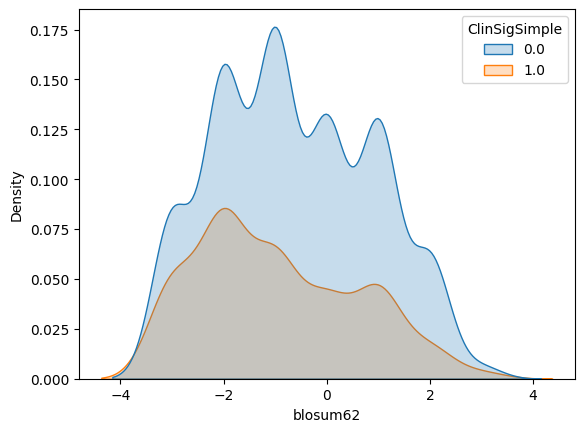

In [50]:
sns.kdeplot(complete_dataset,x='blosum62',hue='ClinSigSimple',fill=True)

Distribucija blosum62 score-a pokazuje visoko preklapanje izmedju benignih i patogenih varijanti. Patogene varijante imaju nize prosecne 

vrednosti ovog score-a, medijane i interkvartalni opsezi su identicni. Ovaj feature ima jak bioloski smisao ali ogranicenu diskriminativnu moc

kada se posmatra samostalno. Ocekujem da ce imati slabiju korelaciju sa targetom u analizi kasnije.


### 6. **alphamissense_score**

In [51]:
complete_dataset.groupby('ClinSigSimple')['alphamissense_score'].describe()

,count,mean,std,min,25%,50%,75%,max
ClinSigSimple,,,,,,,,
0.0,942.0,0.429072,0.369874,0.0393,0.09090,0.25085,0.849025,0.9997
1.0,434.0,0.721502,0.359574,0.0530,0.40025,0.95615,0.995200,0.9999


Patogena klasa (1) ima znatno vise vrednosti ovog score-a. Medijana za patogenu klasu je na gornjoj granici (0.95)

Alphamissense score pokazuje jasnu diskriminativnu moc izmedju benigninh i patogenih klasa.

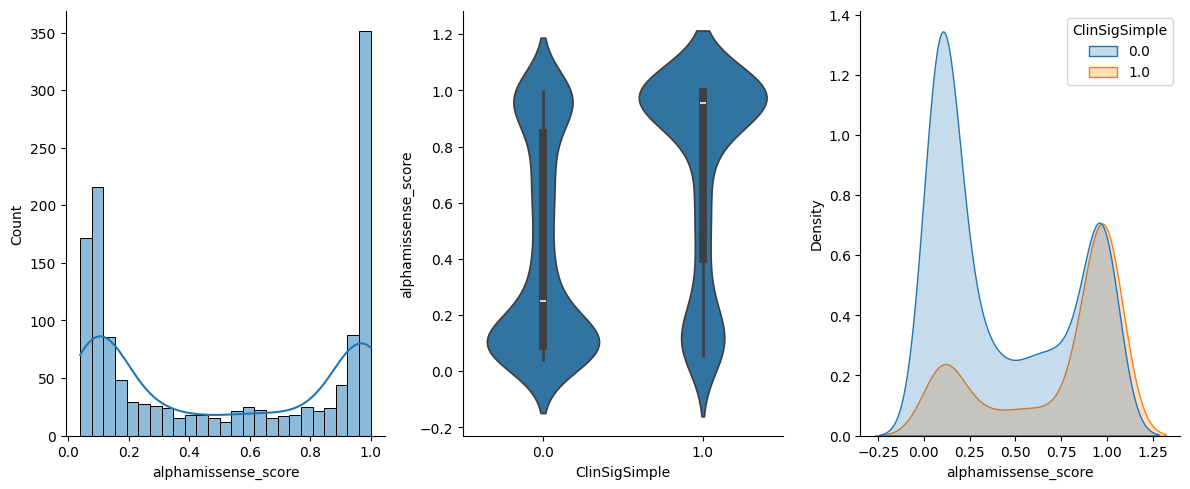

In [52]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,5))
sns.histplot(complete_dataset,x='alphamissense_score',bins=25,kde=True,ax=ax[0])
sns.violinplot(complete_dataset,x='ClinSigSimple',y='alphamissense_score',ax=ax[1])
sns.kdeplot(complete_dataset,x='alphamissense_score',fill=True,hue='ClinSigSimple',ax=ax[2])
sns.despine(top=True,right=True)
plt.tight_layout()

### __Kategorijski feature-i__ 

- crosstab (feature x target)

### 1. **Impact**

In [53]:
X_categoric.columns

Index(['impact', 'consequence'], dtype='object')

In [54]:
X_categoric['impact'].value_counts()

impact
MODERATE    1383
LOW          721
MODIFIER     363
HIGH         179
Name: count, dtype: int64

In [55]:
ct = pd.crosstab(X_categoric['impact'],complete_dataset['ClinSigSimple']).rename(columns={0.0:'benign',1.0:'pathogenic'})
ct.columns
ct

ClinSigSimple,benign,pathogenic
impact,,
HIGH,109,68
LOW,639,80
MODERATE,942,434
MODIFIER,323,35


- normalizacija po redovima, za jasniji prikaz udela patogenih tj. benignih varijanti u uzorku

In [56]:
ct_norm=ct.apply(lambda x: x/sum(x),axis=1)
ct_norm

ClinSigSimple,benign,pathogenic
impact,,
HIGH,0.615819,0.384181
LOW,0.888734,0.111266
MODERATE,0.684593,0.315407
MODIFIER,0.902235,0.097765


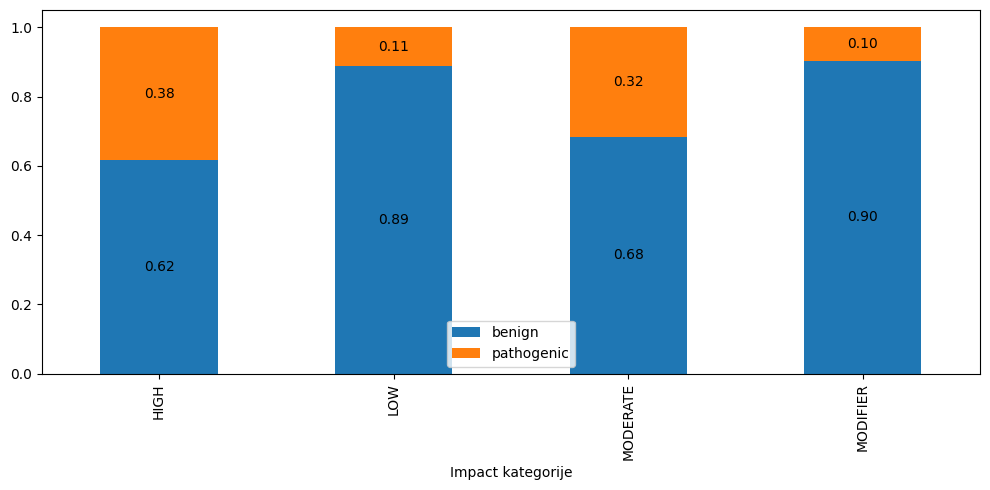

In [57]:
ax = ct_norm.plot(kind='bar',stacked=True,figsize=(10,5))
plt.xlabel('Impact kategorije')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f',label_type='center')
plt.legend(loc='lower center')
plt.tight_layout()


Varijante sa višim predviđenim molekularnim uticajem (HIGH i MODERATE) imaju znatno veći udeo patogenih varijanti (0.38 i 0.32%) u poređenju sa 

kategorijama  LOW i MODIFIER (0.11 i 0.10%).

Smatram da ovi rezultati potvrđuju da impact anotacija nosi relevantnu i diskriminativnu informaciju za binarnu klasifikaciju varijanti.

### 2. **Consequence**

In [58]:
X_categoric['consequence'].value_counts()

consequence
missense_variant                       1383
synonymous_variant                      462
intron_variant                          287
splice_region_variant                   120
splice_polypyrimidine_tract_variant      89
stop_gained                              89
splice_donor_variant                     44
3_prime_UTR_variant                      39
splice_acceptor_variant                  39
splice_donor_region_variant              31
downstream_gene_variant                  21
splice_donor_5th_base_variant            19
5_prime_UTR_variant                      16
stop_lost                                 7
Name: count, dtype: int64

In [59]:
ct2 = pd.crosstab(X_categoric['consequence'],complete_dataset['ClinSigSimple']).rename(columns={0.0:'benign',1.0:'pathogenic'}).sort_values(by='benign',ascending=False)

Udeo patogenih/benignih u okviru svake podkategorije

In [60]:
consequence_normalize = ct2.apply(lambda row:(row/sum(row)).round(2),axis=1)
consequence_normalize.sort_values(by='pathogenic',ascending=False)

ClinSigSimple,benign,pathogenic
consequence,,
stop_gained,0.61,0.39
splice_acceptor_variant,0.61,0.39
splice_donor_variant,0.63,0.37
missense_variant,0.68,0.32
stop_lost,0.71,0.29
5_prime_UTR_variant,0.75,0.25
splice_donor_region_variant,0.77,0.23
splice_region_variant,0.83,0.17
splice_donor_5th_base_variant,0.84,0.16


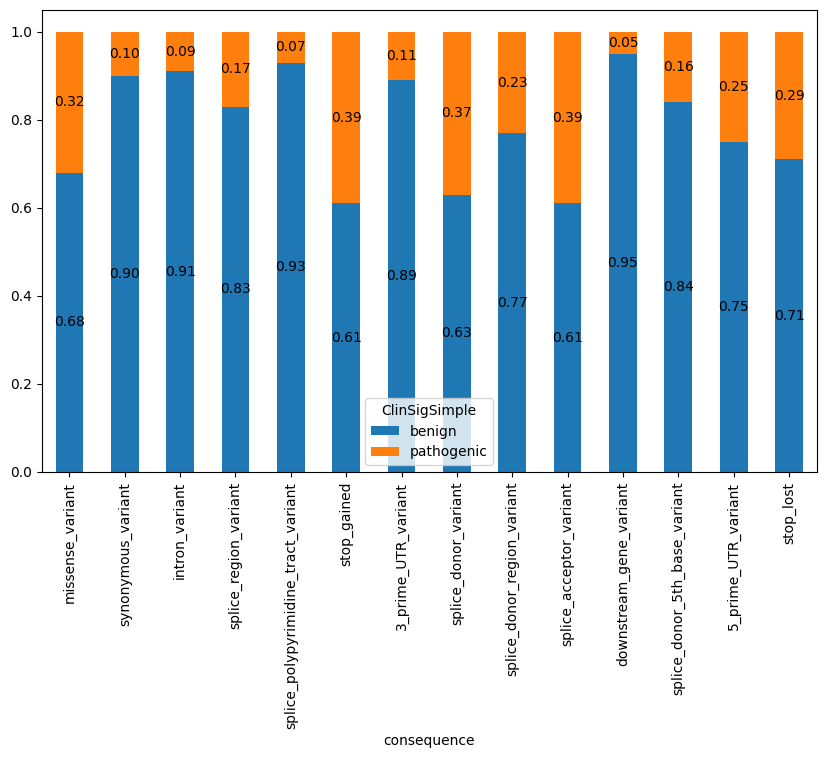

In [61]:
ax2 = consequence_normalize.plot(stacked=True,kind='bar',figsize=(10,6))
for container in ax2.containers:
    ax2.bar_label(container,label_type='center',fmt='%.2f')

In [62]:
# numericke kolone , df
X_numeric

,cadd_phred,cadd_raw,revel,sift_score,blosum62,alphamissense_score
0,29.20,5.203168,0.927,0.00,-3.0,0.9968
1,25.30,4.453018,0.961,0.00,1.0,0.9918
2,27.50,4.936062,0.970,0.00,-3.0,0.9965
3,24.90,4.298395,0.952,0.00,-3.0,0.9967
4,12.91,1.299883,0.368,0.14,-2.0,0.0724
...,...,...,...,...,...,...
2658,NaN,NaN,NaN,NaN,NaN,NaN
2659,NaN,NaN,NaN,NaN,NaN,NaN
2660,NaN,NaN,NaN,NaN,NaN,NaN
2661,NaN,NaN,NaN,NaN,NaN,NaN


Heatmap 1 - samo numericki feature-i ( istrazivanje intenziteta vrednosti )

<Axes: >

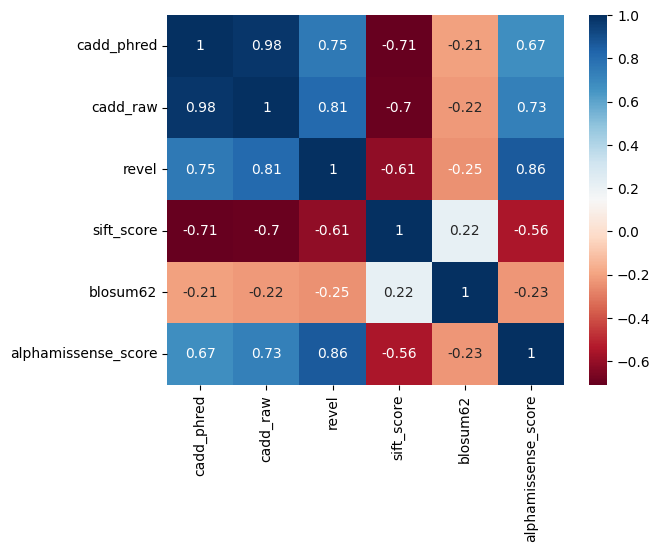

In [63]:
sns.heatmap(X_numeric.corr(),cmap='RdBu',annot=True)

#### 1. Jako __pozitivno__ korelisani feature-i:

cadd_raw i cadd_phred = 0.98

revel i alphamissensce_score = 0.86

carr_raw i revel = 0.81

cadd_raw i cadd_phred - ocekivana visoka vrednost corr. jer je cadd_phred izvedena transformacija iz cadd_raw score-a. 


Primecena je jaka pozitivna korelacija između više skorova koji procenjuju potencijalnu patogenost varijanti (CADD, REVEL, AlphaMissense). Ovakva korelacija je ocekivana, s obzirom da svi ovi score-ovi integrisu slicne informacije o evolutivnoj konzervaciji i funkcionalnom efektu varijante.

#### 2. Negativne korelacije

__sift_score__ VS Cadd_phred, cadd_raw, revel i alphamissense_score


sift_score pokazuje umerenu do jaku negativnu korelaciju sa ostalim skorovima patogenosti, iz razloga sto kod ovog score-a, njegove nize 

vrednosti ukazuju na veci patogeni efekat, gde god ostalih score-ova , vise vrednosti = veca patogenost.

#### 3. Slabe korelacije

__blosum62__ pokazuje obrazac slabih korelacija sa ostalim numerickim feature-ima.

### Analiza korelacije pokazuje odredjenu ocekivanu redundantnost izmedju odredjenih patogenih score-ova, ali i prisustvo feature-a sa nezavisnom informacijom (__blosum62__).

## Numericki feature-i i target feature

In [64]:
target = complete_dataset['ClinSigSimple']
X_numeric['target'] = target

<Axes: >

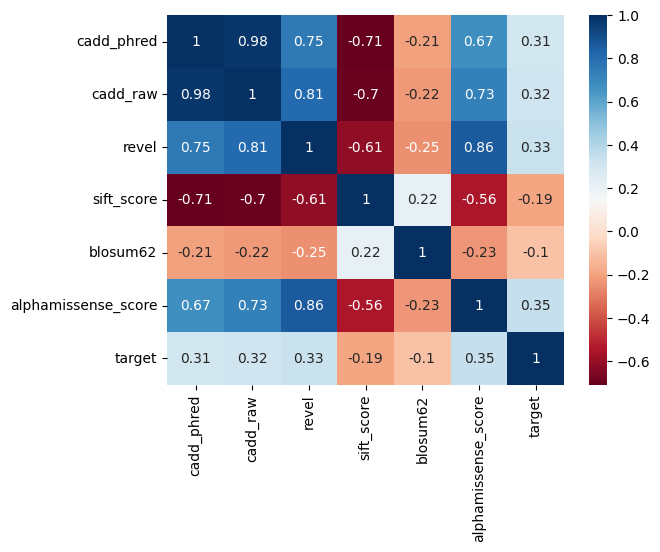

In [65]:
sns.heatmap(X_numeric.corr(),cmap='RdBu',annot=True)

__blosum62__ = -0.1  -> Pokazuje slabu korelaciju sa target promenljivom i samostalno ne doprinosi razdvajanju izmedju klasa target promenljive.

__sift_score__ = -0.19 -> Negativna korelacija sa ciljnom promenljivom sto je ocekivano u ovom slucaju zbog bioloske prirode ovog score-a. 

negativne vrednosti = veca patogenost varijante

__cadd_phred__, __cadd_raw__,__revel__ i __alphamissense_score__ pokazuju umerenu samostalnu korelaciju sa ciljnom promenljivom

## __Data Engineering__ - Odabir promenljivih na osnovu prethodnih analiza

U analizi korelacije izmedju numerickih feature-a, primeceno je da su `cadd_raw` i `cadd_phred` u medjusobnoj visokoj korelaciji ~0.98.

Prateci zvanicnu sugestiju iz literature, preporuceno je zadrzavanje izvedenog i normalizovanog `cadd_phred` score-a.

In [66]:
complete_dataset.drop(columns={'cadd_raw'},inplace=True)

Finalni skup feature-a:

- Target: ClinSigSimple ( binarni )

__Numericki feature-i__:

- cadd_phred

- revel

- sift_score

- blosum62

- alphamissense_score

__Kategorijski feature-i__:

- impact (ordinalni)

- consequence (nominalni)




Razdvajanje EDA i ML dataframe-a, pri cemu ML dataframe sadrzi samo prediktivne promenljive i target varijablu.

In [67]:
ml_data = complete_dataset[['cadd_phred','revel','sift_score','blosum62','alphamissense_score','impact','consequence','ClinSigSimple']]
ml_data

,cadd_phred,revel,sift_score,blosum62,alphamissense_score,impact,consequence,ClinSigSimple
0,29.20,0.927,0.00,-3.0,0.9968,MODERATE,missense_variant,1.0
1,25.30,0.961,0.00,1.0,0.9918,MODERATE,missense_variant,1.0
2,27.50,0.970,0.00,-3.0,0.9965,MODERATE,missense_variant,1.0
3,24.90,0.952,0.00,-3.0,0.9967,MODERATE,missense_variant,1.0
4,12.91,0.368,0.14,-2.0,0.0724,MODERATE,missense_variant,1.0
...,...,...,...,...,...,...,...,...
2658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [68]:
ml_data.to_csv('ml_data.csv')

In [69]:
ml_data.reset_index(drop=True,inplace=True)

In [70]:
y = ml_data['ClinSigSimple']
X = ml_data.drop(columns={'ClinSigSimple'})


#### Izbacujem ukupno 17 varijanata kod kojih je NaN za ceo red u (X) feature prostoru:

Identifikujem indeks i dropujem iz trening set-a



In [71]:
idx = X.index[X.isna().all(1)]

In [72]:
X = X.drop(index=idx)
y = y.drop(index=idx)

In [73]:
print(X.shape,y.shape)

(2630, 7) (2630,)


In [74]:
ml_data = pd.concat([X,y],axis=1).rename(columns={'ClinSigSimple':'Target'})

In [75]:
ml_data.isna().sum()

cadd_phred                0
revel                  1254
sift_score             1254
blosum62               1254
alphamissense_score    1254
impact                    0
consequence               0
Target                    0
dtype: int64

### __Data Preprocessing__ 

##### 1) __Nedostajuce vrednosti, Imputacije, Enkoderi, Scaler (LogReg)__

##### 2) __Stratifikovani train_test_split__
---

U ovom dataset-u identifikovane su nedostajuce vrednosti za kolone kolone __sift_score__, __blosum62__, __revel__, __alphamissense_score__. 

### 1. Bioloski uslovljene (`MNAR` - missing not at random) nedostajuce vrednosti

za numericke score-ove:

- Revel

- sift_score

- blosum62

- alphamissense_score

Ovi score-ovi se izracunavaju iskljucivo za određene tipove varijanti (uglavnom missense), dok za ostale molekularne posledice ne postoje po definiciji. 

Zbog toga su ove nedostajuce vrednosti tretirane kao informativne, a ne kao šum u podacima.

Ovde bih primenio `mean` imputer. Na ovaj način smatram da bi model trebalo da prepozna vrednost koja nedostaje kao signal za predikciju tj. model bi mogao da uci iz tog missing obrasca. (__moja pretpostavka__)

Svi feature-i sa missing vrednostima:

In [76]:
cols_with_miss = [col for col in ml_data if ml_data[col].isna().any()]
cols_with_miss

['revel', 'sift_score', 'blosum62', 'alphamissense_score']

In [77]:
ml_data.isna().sum()

cadd_phred                0
revel                  1254
sift_score             1254
blosum62               1254
alphamissense_score    1254
impact                    0
consequence               0
Target                    0
dtype: int64

In [78]:
#preprocessing biblioteke
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import MissingIndicator

In [79]:
#model biblioteke
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#### __DummyClassifier__ 

##### Uvodim __DummyClassifier__  koji nasumicno klasifikuje predikcije, pri cemu __most_frequent__ parametar, predvidja najcescu klasu. Na ovaj nacin se moze pokazati da __accuracy__ metrika nije pouzdana mera performansi u nebalansiranom datasetu, jer i trivijalan model moze ostvariti visoku tacnost bez stvarne prediktivne moći.

##### Osnovni model u ovoj klasifikaciji je LogisticRegression, koji cu uporediti sa kompleksnijim modelima. Uvodim parametar class_weight sa vrednoscu __balanced__ što omogućava jacu regularizaciju klase koja je u manjini (1 pathogenic) i na taj nacin omogucava da je model bolje uci.
##### Zbog nebalansiranosti klasa, evaluacija modela se ne zasniva na accuracy metriki, vec se prioritet daje metrikama kao sto su **recall** i **PR-AUC**, koje bolje prikazuju sposobnost modela da prepozna patogene varijante.

Random state je definisan zbog reproducibilnosti.


In [80]:
models = {
    'Dummy':DummyClassifier(strategy='most_frequent'), 
    'LogReg':LogisticRegression(class_weight='balanced',random_state=42),
    'DecisionTree':DecisionTreeClassifier(class_weight='balanced',random_state=42),
    'RandomForest':RandomForestClassifier(class_weight='balanced',random_state=42),
    'GB':GradientBoostingClassifier(random_state=42)
}

__ColumnTransformer__ iz sklearn biblioteke, je prikladna preprocessing metoda koju sam koristio za primenu transformacija toko preprocessing-a. 
ColumnTransformer je slican kao i make_column_transformer, pri cemu kod ColumnTransformer-a, neophodno je definisati u okviru liste: (ime, __transformer__,kolonu na kojoj primenjujemo). Parametar __remainder__ odredjuje sta se desava sa kolonama koje nisu uzete u obzir tokom transformacija. U oba slucaja, zadrzavam sve nepromenjene kolone ('passthrough').

#### Napravljene su 2 promenljive, sa prikladnim transformerima, koji ce biti deo Pipe objekta kasnije:

##### 1. __preprocess_linear__ namenjen za linearni model tj. Logisticku regresiju i ukljucuje primenu RobustScaler-a. RobustScaler ovde primenjujem na cadd_phred koloni zbog sirokog opsega vrednosti, i za ovaj scaler sam se odlucio jer koristi medianu i interkvartilni opseg (IQR), čime se smanjuje uticaj ekstremnih vrednosti na proces ucenja linearnog modela.

In [81]:
preprocessor_linear = ColumnTransformer([
    ('scaler',RobustScaler(),['cadd_phred']),
    ('imputer_nans',SimpleImputer(strategy='mean'),['revel','sift_score','blosum62','alphamissense_score']),
    ('ordinal',OrdinalEncoder(),['impact']),
    ('oneHot',OneHotEncoder(sparse_output=False),['consequence'])],
    remainder='passthrough')

##### 2. __preprocessor_other__ namenjen za ostale robusne ensebml/tree modele koje planiram da testiram. U ovom preprocessoru, Scaler je izostavljen jer modeli zasnovani na stablima odlucivanja __nisu osetljivi__ na skalu ulaznih promenljivih. Podele u cvorovima ovih modela ne zavise od apsolutnih vrednosti feature-a. 


In [82]:
preprocessor_other = ColumnTransformer([
    ('imputer_nans',SimpleImputer(strategy='mean'),['revel', 'sift_score','blosum62','alphamissense_score']),
    ('ordinal',OrdinalEncoder(),['impact']),
    ('oneHot',OneHotEncoder(sparse_output=False),['consequence'])],
    remainder='passthrough')

Consequence je enkodiran pomoću OneHotEncoder-a, dok je impact enkodiran OrdinalEncoder-om zbog postojanja prirodnog redosleda kategorija.

## **Modeliranje**

Za podelu na trening/validacioni set primenicu __Stratified K-fold CV__ koji obezbedjuje istu distribuciju klasa u svakom fold-u. Hold out set je zadrzan za testiranje. 

Kfold Cross Validation pravi foldove prema zadatom parametru k. U svakoj od k iteracija:

- 1 fold je test set

- k - 1 su trening setovi

---

In [83]:
y_vals = y.value_counts()
total = sum(y_vals)
y_pd = pd.DataFrame({'broj_uzoraka':y_vals}).rename(columns={'ClinSigSimple':'Target'})
y_pd['%'] = y_pd.apply(lambda row: row/total*100).round(2)
y_pd

,broj_uzoraka,%
ClinSigSimple,,
0.0,2013,76.54
1.0,617,23.46


In [84]:
skf = StratifiedKFold(n_splits=10)
# br.split je 10, jer je dataset mali
models

{'Dummy': DummyClassifier(strategy='most_frequent'),
 'LogReg': LogisticRegression(class_weight='balanced', random_state=42),
 'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
 'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
 'GB': GradientBoostingClassifier(random_state=42)}

#### Pozivanjem StratifiedKFold .split() metode, prosledjujem ceo X (trening) i ceo y (target) set podataka. Ova metoda vraca indekse trening i test podskupova za svaki split, koje zatim uz __.iloc__ izvdvajam: X_train, X_test, y_train i y_test.

In [85]:
trained_models_storage = []
for fold,(train_index,test_index) in enumerate(skf.split(X,y),1): # enumerate nije neophodan vec sam ga dodao da bih na kraju samo prikazao koji se fold procesuira
    print(f'Fold {fold}, processing...')
    X_train,X_test = X.iloc[train_index],X.iloc[test_index] 
    y_train,y_test =  y.iloc[train_index],y.iloc[test_index]

    for name,model in models.items():
        if name =='LogReg':
            pipe = make_pipeline( #pipe za Logreg, prosledjujem preprocessor_linear + model
                preprocessor_linear,
                model)
            pipe.fit(X_train,y_train)
            trained_models_storage.append(pipe)
        else:
            pipe = make_pipeline(
                preprocessor_other,
                model
            )
            pipe.fit(X_train,y_train)
            trained_models_storage.append(pipe)
    print(f'Fold {fold}: done')
    print(f'{"--"*15}')


Fold 1, processing...
Fold 1: done
------------------------------
Fold 2, processing...
Fold 2: done
------------------------------
Fold 3, processing...
Fold 3: done
------------------------------
Fold 4, processing...
Fold 4: done
------------------------------
Fold 5, processing...
Fold 5: done
------------------------------
Fold 6, processing...
Fold 6: done
------------------------------
Fold 7, processing...
Fold 7: done
------------------------------
Fold 8, processing...
Fold 8: done
------------------------------
Fold 9, processing...
Fold 9: done
------------------------------
Fold 10, processing...
Fold 10: done
------------------------------


In [86]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,roc_auc_score

##### Pravljenje recnika, spajanjem imena modela i fitovanih pipe-ova kroz dict(zip()). __model__ predstavlja __value__ deo ovo konstruisanog recnika, pri cemu se za LogReg koristi pipe koji je prethodno spojen tj (preprocessor_linear + model), dok se za ostale koristi (preprocessor_other + model)

##### Metrike se cuvaju u model_output listi

In [87]:
model_output = []
for i,(name,model) in enumerate(dict(zip(models,trained_models_storage)).items()): #
    if name == 'LogReg':
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:,1]
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:,1]
    metrics = {
        'model':[name for name,_ in models.items()][i],
        'f1_score':f1_score(y_test,y_pred),
        'accuracy_score':accuracy_score(y_test,y_pred),
        'recall_score':recall_score(y_test,y_pred),
        'precision_score':precision_score(y_test,y_pred),
        'roc_auc_score':roc_auc_score(y_test,y_pred_proba)
        
    }
    model_output.append(metrics)

c:\Users\Admin\ML\venv1\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [88]:
df_baseline_metrics = pd.DataFrame(model_output).drop([0],axis='index').sort_values(by='f1_score',ascending=False)
df_baseline_metrics

,model,f1_score,accuracy_score,recall_score,precision_score,roc_auc_score
1,LogReg,0.259259,0.695817,0.229508,0.297872,0.547395
2,DecisionTree,0.153846,0.665399,0.131148,0.186047,0.477560
3,RandomForest,0.139535,0.718631,0.098361,0.240000,0.574176
4,GB,0.027397,0.730038,0.016393,0.083333,0.567846


## __Evaluacija osnovnih modela__:

True positives - tacne pozitivne predikcije

False Positives - lazne pozitivne predikcije - (Tip 1 greska)

True Negatives - tacne negativne predikcije

False Negatives - lazne negativne predikcije - (Tip 2 greska)

#### 1. __Tacnost__ (accuracy score)

Tacnost modela ima značajna ograničenja kada je reč o nebalansiranom datasetu. Sa obzirom na činjenicu da je većina klasa (0 - benign, __76%__), modeli većinski predviđaju negativnu klasu, dok je cilj da modeli predvidjaju sto bolje pozitivnu klasu (1 - pathogenic).

Iz tog razloga, preciznost modela nije toliko znacajan parametar prilikom evaluacije.

Racuna se po formuli:

TP + TN / TP + TN + FP + FN


#### 2. __Recall__ (sensitivity)

Recall skor predstavlja ukupan broj pozitivnih predikcija. Model bi mogao da postigne visok __Recall__ tako sto sve predvidja kao pozitivnu klasu, na racun povecanja False Positive i smanjenje __precision__-a. Racuna se po formuli: 

- True positives / True positives + False Negatives

U ovom datasetu, Recall skor je najbitnija metrika jer je neophodno predvideti vecinu pozitivnih uzoraka, uz svesno smanjenje preciznosti modela.

U ovom slucaju, f1 score predstavlja __trade off__ izmedju ove dve metrike.

Cilj je balans izmedju visokog Recall-a i prihvatljive Precision skor vrednosti.




#### 3. __Preciznost__ (precision score)



Precision skor prikazuje tacnost pozitivnih predikcija tj. od ukupno XYZ pozitivnih, koliko je zaista True Positives.
Racuna se po formuli:

- TP / TP + FP

### 4. __F1 score__

Predstavlja harmonijsku srednju vrednost izmedju Recall i Precision skorova. Racuna se po formuli:

- 2 * (precision * recall) / (precision + recall) 

Kod analiziranih modela, F1 skor je veoma mali. Ovo implicira da modeli jako tesko detektuju pozitivnu klasu i da je recall skor veoma nizak.

Kod Gradient Boosting algoritma, F1 i Recall iznose 0.

In [89]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_curve,precision_recall_curve
from sklearn.model_selection import cross_val_predict

- prilikom evaluacije, u obzir sam uzeo postojanje 10 foldova. Koriscenje jednog X_testa bilo bi pogresno jer u ovom slucaju to predstavlja samo 10% podataka i nije reprezentativno

- Koriscenjem __cross_val_predict__ omoguceno je dobijanje predikcija iz svakog test fold-a (ref. [https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation])

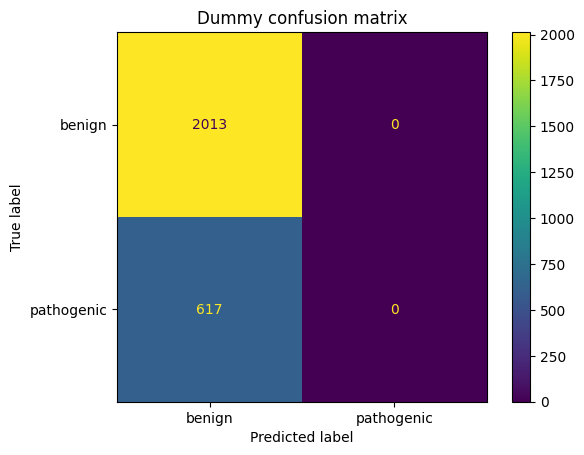

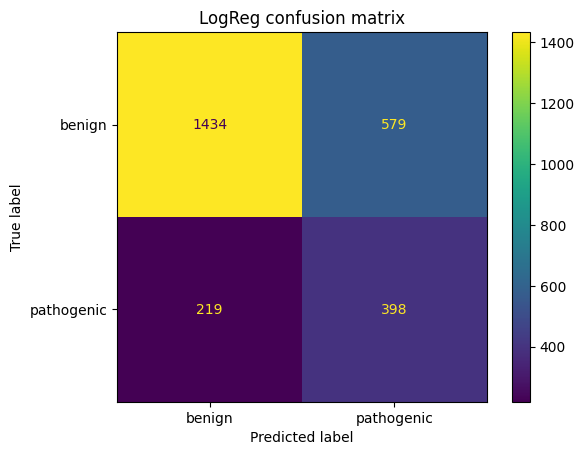

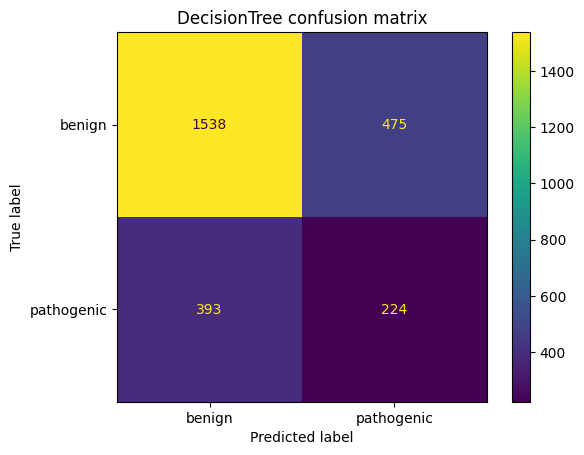

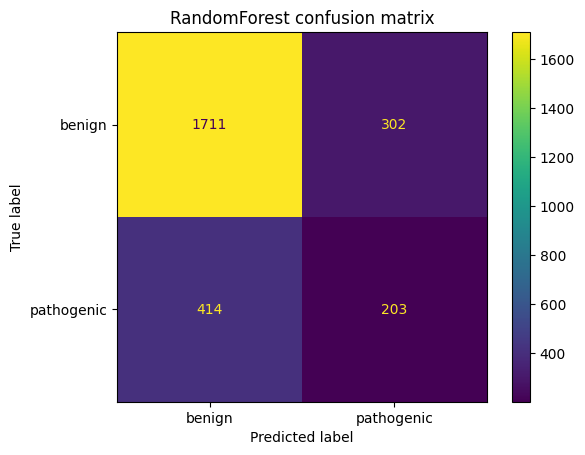

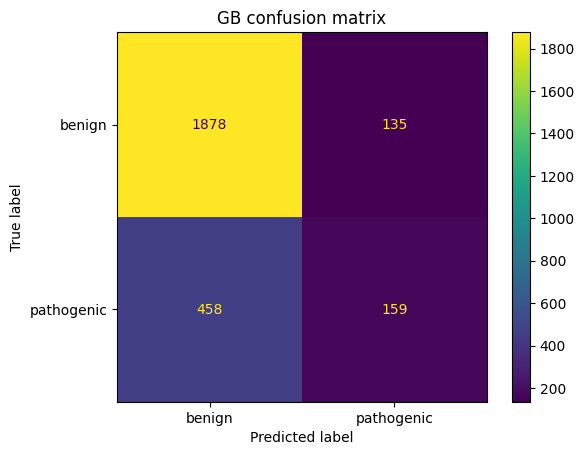

In [90]:
y_pred_crossval = {}
cv = StratifiedKFold(n_splits=10)
for name,model in models.items():
    if name == "LogReg":
        pipe = make_pipeline(preprocessor_linear,model)
    else:
        pipe = make_pipeline(preprocessor_other,model)
    
    y_pred_crossval[name] = cross_val_predict(pipe,X,y,cv=cv,method='predict')

    #ConfusionMatrix

    cm = confusion_matrix(y,y_pred_crossval[name])
    display_cm = ConfusionMatrixDisplay.from_predictions(y,y_pred_crossval[name],display_labels=['benign','pathogenic'])
    display_cm.ax_.set_title(f"{name} confusion matrix")




##### Obelezavanjem patogene varijante (klasa 1) kao benigne (klasa 0) postize se lazno negativan rezultat (Greska tip 2) sto bi bila velika greska. Sa tim u vezi, cilj je optimizacija senzitivnosti tj `Recall` vrednosti uz prihvatljivo smanjenje `Precision`-a

In [91]:
def get_metrike():
    cv = StratifiedKFold(n_splits=10)
    metrike = {}
    for name,model in models.items():
        if name == "LogReg":
            pipe = make_pipeline(preprocessor_linear,model)
        else:
            pipe = make_pipeline(preprocessor_other,model)
        y_pred_proba = cross_val_predict(pipe,X,y,cv=cv,method='predict_proba')[:,1]
        res = {}
        #roc
        fpr,tpr,threshold_roc = roc_curve(y,y_pred_proba)
        res['ROC'] = {
            'ime krive':name,               
            'fpr':fpr,
            'tpr':tpr,
            'thresholds':threshold_roc
            }
        #pr
        precision,recall,threshold_pr = precision_recall_curve(y,y_pred_proba)

        res['PR'] = {
            'ime krive':name,
            'precision':precision,
            'recall':recall,
            'threshold_pr':threshold_pr
        }
        metrike[name] = res
    return metrike
metrike = get_metrike()

In [92]:
for name,values in metrike.items():
    print(values['ROC']['fpr'])

[0. 1.]
[0.00000000e+00 4.96770989e-04 2.48385494e-03 2.48385494e-03
 2.98062593e-03 2.98062593e-03 3.97416791e-03 3.97416791e-03
 4.96770989e-03 4.96770989e-03 5.46448087e-03 5.46448087e-03
 5.96125186e-03 5.96125186e-03 6.95479384e-03 6.95479384e-03
 7.94833582e-03 7.94833582e-03 8.94187779e-03 8.94187779e-03
 9.43864878e-03 9.43864878e-03 9.93541977e-03 9.93541977e-03
 1.19225037e-02 1.19225037e-02 1.34128167e-02 1.34128167e-02
 1.39095877e-02 1.39095877e-02 1.49031297e-02 1.49031297e-02
 1.58966716e-02 1.58966716e-02 1.68902136e-02 1.68902136e-02
 1.78837556e-02 1.78837556e-02 1.83805266e-02 1.83805266e-02
 1.88772976e-02 1.88772976e-02 1.93740686e-02 1.93740686e-02
 2.08643815e-02 2.08643815e-02 2.13611525e-02 2.13611525e-02
 2.18579235e-02 2.18579235e-02 2.28514655e-02 2.28514655e-02
 2.33482365e-02 2.33482365e-02 2.43417784e-02 2.43417784e-02
 2.48385494e-02 2.48385494e-02 2.53353204e-02 2.53353204e-02
 2.63288624e-02 2.63288624e-02 2.68256334e-02 2.68256334e-02
 2.78191754e-02 

plt.subplots(1, 2) kreira dve figure rasporedjene u jednom redu i dve kolone. Lista line_colors je improvizacija boja za linije na plotu. 

Objekat ax[0] odnosi se na prvi subplot, dok ax[1] predstavlja drugi.

DummyClassifier je na ROC–AUC krivoj prikazan isprekidanom crvenom linijom ('r--').

C:\Users\Admin\AppData\Local\Temp\ipykernel_32556\1943959069.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()


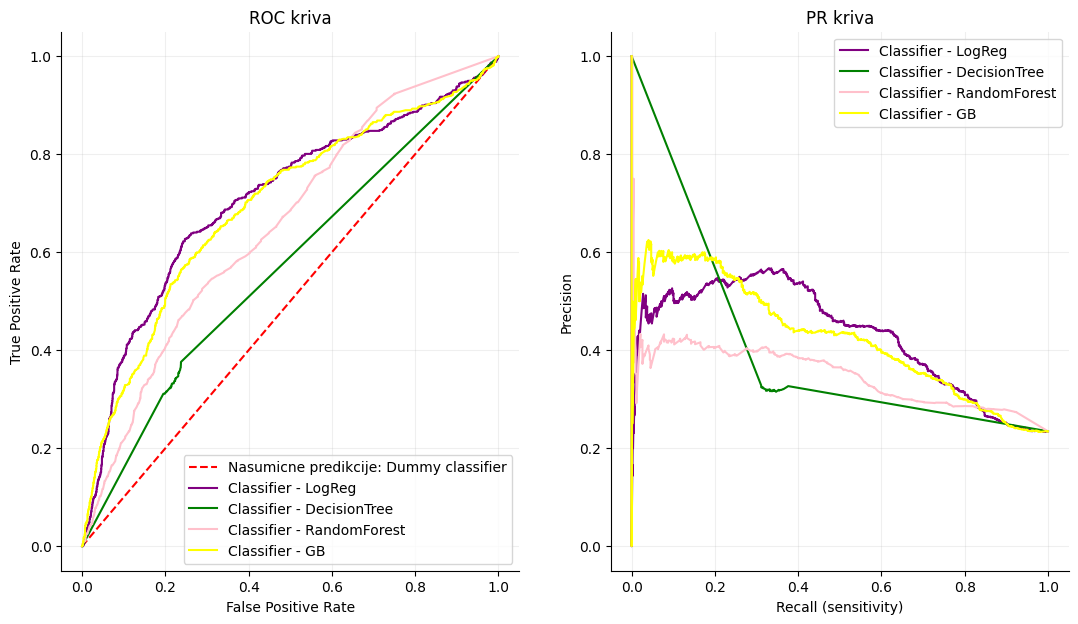

In [93]:
def plot_krive(data):
    fig,ax = plt.subplots(1,2,figsize=(13,7))
    line_colors = ['blue','purple','green','pink','yellow']
    
    for i,(name,values) in enumerate(data.items()):
    
        if name == 'Dummy':
            ax[0].plot([0,1],[0,1],linestyle='--',color='red',label=f'Nasumicne predikcije: {name} classifier')
        else:
            ax[0].plot(values['ROC']['fpr'],values['ROC']['tpr'],label=f'Classifier - {name}',color =line_colors[i]) # ROC
            ax[1].plot(values['PR']['recall'],values['PR']['precision'],label=f'Classifier - {name}',color=line_colors[i]) #PR

        ax[0].set(title='ROC kriva',xlabel='False Positive Rate',ylabel='True Positive Rate',label=f"{df_baseline_metrics['roc_auc_score']}")
        ax[1].set(title='PR kriva',xlabel='Recall (sensitivity)',ylabel='Precision')
        for i in range(len(ax)):
            ax[i].legend()
            ax[i].grid(alpha=.2)
            ax[i].spines[['top','right']].set_visible(False)
        
        



plot_krive(data=metrike)    

In [94]:
df_baseline_metrics

,model,f1_score,accuracy_score,recall_score,precision_score,roc_auc_score
1,LogReg,0.259259,0.695817,0.229508,0.297872,0.547395
2,DecisionTree,0.153846,0.665399,0.131148,0.186047,0.477560
3,RandomForest,0.139535,0.718631,0.098361,0.240000,0.574176
4,GB,0.027397,0.730038,0.016393,0.083333,0.567846


## Analiza:

#### 1) __ROC__ kriva:

ROC-AUC kriva pokazuje diskriminativnu moc modela izmedju binarnih klasa (0-benign, 1-pathogenic). AUC predstavlja verovatnoću da model dodeli višu predikcionu vrednost pozitivnom uzorku nego negativnom. AUC vrednost od 1 bi oznacavala savrsenu klasifikaciju dok je 0.5 isto sto i nasumicno pogadjanje modela (DummyClassifier)

#### 2) __PR AUC__ kriva:

Prikazuje odnos izmedju ukupno identifikovanih pozitivnih uzoraka (TP) sa brojem zaista tacnih pozitivnih uzoraka (precision). __Precision-Recall__ kriva je u slucaju ovog dataset znatno pogodnija, jer je pozitivna klasa (1 - `pathogenic`) u manjem broju od negativne klase ( 0- `benign`). Perfektna kriva bila bi sa precision = 1 i recall = 1 sto odgovara gornjem desnom uglu PR prostora.

Nagli pad Precision-a pri malim vrednostima Recall-a je posledica granicne vrednosti (threshold), pri kojem model sa sigurnoscu idenifikuje mali broj sigurnih pozitivnih uzoraka.
U kontekstu ovog dataseta, cilj je minimizacija False negative gresaka tj. propustene patogene varijante. Prema tome, pokusacu da optimizujem recall vrednost.


### Vizuelizacija efekta granicnih vrednosti na __Recall__ i __Precision__ skorove

In [95]:
#izbacivanje dummy
selected_models = list(models)[1:]
selected_models

['LogReg', 'DecisionTree', 'RandomForest', 'GB']

In [96]:
#izbacivanje dummy pipe-a
trained_models_storage = trained_models_storage[1:]

In [97]:
def pr_thresholds_kriva(pipe):
   results = []
   fig,ax = plt.subplots(2,2,figsize=(8,6))
   for i,(name,model) in enumerate(zip(selected_models,pipe)):
      
      row = i // 2  # 0// 2 = 0, prvi red i 1 // 2 = 0 drugi red
      col = i % 2   
   
      y_scores = cross_val_predict(model,X,y,cv=StratifiedKFold(n_splits=10),method='predict_proba')[:,1]

      #PR
      precision, recall, thresholds = precision_recall_curve(y, y_scores)
      ax[row, col].plot(thresholds, precision[:-1], "b--", label="Precision")
      ax[row, col].plot(thresholds, recall[:-1], "g--", label="Recall")
      ax[row, col].set_title(f'Recall-PR kriva: {name}')
      ax[row, col].set_xlabel("Thresholds")
      ax[row, col].legend()

   plt.tight_layout()
   plt.show()

   return results


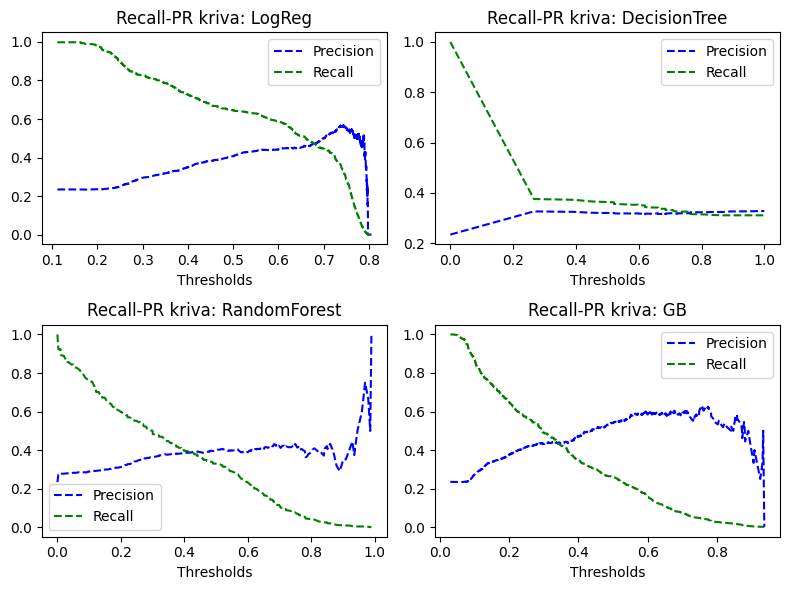

In [98]:
test = pr_thresholds_kriva(trained_models_storage)

Vizuelizacija prikazuje Precision/Recall odnos u funkciji Threshold-a. Ono sto se moze zakljuciti je:

1) Logisticka regresija pokazuje dobar __trade_off__ izmedju ove dve metrike i verovatno je najbolji kandidat za __optimizaciju praga odlucivanja__

2) Decision Tree pokazuje nagli pad recall skor-a tj. model jako brzo prestaje da predvdidja pozitivnu klasu. DT donosi odluke u cvorovima koji se odnose na najcescu klasu. Smatram da ovaj model nije dobar kandidat za optimizaciju praga odlucivanja.

3) Random Forest je znatno bolji od jednog stabla, ali na visokim thresholdima vidi se skok u precision-u.

4) GradientBoosting pokazuje uravnotezen odnos izmedju precision/recall sto je verovatno povezano sa cinjenicom da ovaj model iterativno ispravlja greske prethodnih modela i na taj nacin uspeva da zadrzi dobar balans. GB bi bio mozda najpogodniji u situaciji maksimalne optimizacije F1 skor-a.

#### Biranje praga odlucivanja koji obezbedjuje visoku vrednost Recall skore-a u cilju smanjenja broja False Negative predikcija uz prihvatljiv porast broja lazno pozitivnih predikcija

Testiram nekoliko Recall vrednosti:

In [99]:
target_recall = [0.7, 0.8, 0.85, 0.9, 0.95]

In [100]:
def optimize_recall(pipe,target_recalls):
    """
    Za svaki model, testira se svaka ciljana vrednost recall-a, kao output, vracen je DataFrame
    
    FN i FN izvlacim iz poravnanja ConfusionMatrix-a

    U prvoj petlji iteracija se vrsi kroz trenirani pipe za modele, i u okviru svakog modela radi se iteracija kroz zadate ciljane recall vrednosti

    """
    results = []
    for name,model in zip(selected_models,pipe):
    
        y_pred_proba = cross_val_predict(model,X,y,cv=StratifiedKFold(n_splits=10),method='predict_proba')[:,1]
        
        #PR kriva
        precisions,recalls,thresholds = precision_recall_curve(y,y_pred_proba)
  

        """
        Za svaki model, testira se svaki zadati recall pri cemu trazim indekse gde je dobijeni recall modela sigurno jedan ili veci od zadatog target_recall parametra
        """

        for recall in target_recalls:
            indeks = np.where(recalls>=recall)[0] #indeksi gde je recall > ili = od target recall-a

            #za svaki target recall, uzimaju se indeksi pozicije
            
            best_indeks = indeks[np.argmax(precisions[indeks])] # najbolji indeksi = za recall od zeljenog praga, uzmi samo one recall indekse gde je max vrednost precision-a
            
            izabrani_prag = thresholds[best_indeks]
            y_pred = (y_pred_proba >= izabrani_prag).astype(int)
            _,fp,fn,_ = confusion_matrix(y,y_pred).ravel()

            results.append({
                'model':name,
                'target recall':recall,
                'threshold':izabrani_prag,
                'best precision':precisions[best_indeks],
                'best recall':recalls[best_indeks],
                'f1 score':f1_score(y,y_pred),
                'Faslse positives':fp,
                'False negatives': fn
            })    

    return pd.DataFrame(results)
         

metrics_df = optimize_recall(trained_models_storage,target_recall)

In [101]:
metrics_df

,model,target recall,threshold,best precision,best recall,f1 score,Faslse positives,False negatives
0,LogReg,0.70,0.423257,0.371160,0.705024,0.486305,737,182
1,LogReg,0.80,0.339055,0.314449,0.800648,0.451554,1077,123
2,LogReg,0.85,0.270400,0.265823,0.850891,0.405093,1450,92
3,LogReg,0.90,0.249925,0.251016,0.901135,0.392655,1659,61
4,LogReg,0.95,0.217934,0.237425,0.956240,0.380400,1895,27
5,DecisionTree,0.70,0.000000,0.234601,1.000000,0.380043,2013,0
6,DecisionTree,0.80,0.000000,0.234601,1.000000,0.380043,2013,0
7,DecisionTree,0.85,0.000000,0.234601,1.000000,0.380043,2013,0
8,DecisionTree,0.90,0.000000,0.234601,1.000000,0.380043,2013,0
9,DecisionTree,0.95,0.000000,0.234601,1.000000,0.380043,2013,0


#### Za svaki model, izracunate su metrike u okviru svakog zadatog __Recall__ score-a

In [102]:
best_selected = (metrics_df[metrics_df['best recall']>=0.95]).sort_values(by='best precision',ascending=False).groupby('model').head(1)

In [103]:
best_selected

,model,target recall,threshold,best precision,best recall,f1 score,Faslse positives,False negatives
4,LogReg,0.95,0.217934,0.237425,0.956240,0.380400,1895,27
19,GB,0.95,0.077496,0.236980,0.951378,0.379444,1890,30
6,DecisionTree,0.80,0.000000,0.234601,1.000000,0.380043,2013,0
14,RandomForest,0.95,0.000000,0.234601,1.000000,0.380043,2013,0


## Analiza dobijenih vrednosti

#### __Tree-based__ modeli koriste Gini indeks (0-0.5) i Entropiju (0-1) za izbor splitova. To su funkcije koje dostizu max. kada su klase u cvoru kompletno izbalansirane.

##### Smanjenje Gini necistoce je dominantno vodjeno vecinskom klasom. 

    G = 1 - SUM(Pk^2)  

- Pk je udeo klase _k_ u cvoru
- Vrednost gini (G) je minimalna (0) kada cvor sadrzi samo 1 klasu

##### Information gain je mera smanjenja Gini necistoce nokon formiranja splita i naziva se Gini Gain. Racuna se po formuli:

    GiniGain = Gini(parent) - SUM_i(Nv/N * Gini(child))

##### Alternativni kriterijum je __Entropija__:

    H(p1,p2) = -p1log2(p1) - p2log2(p2)




U slucaju koriscenja entropije kao kriterijuma, IG se racuna po formuli:

IG(S,i)= H(S)- SUM(|Si|/|S|) * H(Si)

- H(s) - entropija dataset-a pre splita
- IG(S,i) - Information gain dataset-a S za atribut i 


##### To znaci da se podela vrsi pod implicitnom logikom da su klase izbalansirane. U takvim situacijama, posto se klasifikacija vrsi vecinskim glasanjem, vecina listova sadrzi elemente **vecinske** klase (klasa 0) sto dovodi do losijih performansi ovih modela.

##### Za RandomForest algoritam, bilo bi znacajno primeniti __resampling__ metod kao npr. Oversampling manjinske klase ili SMOTE koji bi kreirao hibridnu minority klasu (Hybrid resampling using SMOTE-ENN and SMOTE-Tomek to handle data imbalance on EEG signal for seizure detection and classification, Yadav et al.,2025) 
https://www.sciencedirect.com/science/article/pii/S1877050925016564?via%3Dihub 

https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf.

## __Selekcija modela i evaluacija__

Za optimizaciju hiperparametara koristim GridSearch kako bih pretrazio sve moguce kombinacije hiperparametara modela. Koriscena je stratifikovana Kfold Cross validacija na trening skupu. Odvojeni __hold out__ set je rezervisan za finalnu evaluaciju modela u cilju dobijanja objektivne procene generalizacije ovih modela.

---

In [104]:
from sklearn.model_selection import train_test_split

In [105]:
# develompment set i evaluation set (hold out)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,stratify=y,random_state=42)

In [106]:
models = {name: model for name,model in models.items() if name not in ['Dummy']}
models

{'LogReg': LogisticRegression(class_weight='balanced', random_state=42),
 'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
 'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
 'GB': GradientBoostingClassifier(random_state=42)}

In [107]:
# Selektujem trenirani pipe za LogReg i GB
finalni_pipe = []
for name,pipe in zip(models.keys(),trained_models_storage):
    if name in ['LogReg','GB']:
        finalni_pipe.append(pipe)

### __Optimizacija hiperparametara modela__

##### 1) Log.Reg.:

- C hiperparametar - float(0,np.inf). Jacina regularizacije (1/lambda). Manja vrednost = jaca regularizacija. Regularizacija pomaze pri overfitting-u i stabilnosti koeficijenata u prisustvu visoko korelisanih feature-a. Uzimajuci u obizr da baseline modeli nisu pokazali overfitting, kao i da feature-i imaju biolosku interepretaciju i nisu 'noise', smatram da bi bilo ispravno fokusirati se na vece vrednosti parametra `C`, kako bi se omogucilo modelu da bolje iskoristi informaciju iz bioloskih podataka, uz slabu/srednju regularizaciju,
Osnovna vrednost za C je 1.

- Penalty - Tip regularizacije koji se primenjuje na koeficijente modela. `L2` Ridge, penalizuje velike koeficijente i pogodna je za visoko korelisane feature, dok `L1` Lasso, moze dovesti vrednosti koeficijenta do 0, i na taj nacin pored regularizacije primeniti i selekciju feature-a (implicitno).
U ovom datasetu, sa obzirom na tip informacije koji feature-i nose, ne ocekujem veliki broj beskorisnih feature-a, i svi imaju definisano biolosko znacenje. Iz tog razloga bih se fokusirao na ispitivanje `L2` regularizacije

- max_iter - sa 100 iteracija, algoritam nije uspeo da pronadje optimlani set koeficijenata. Iz tog razloga odlucio sam da odmah povecam i testiram 3 kombinacije max. iteracija.

##### 2) GradientBoosting:

- n_estimators - broj iteracija. Povecani broj iteracija u ovom slucaju, jer osnovni model sa standardnim parametrom nije pokazao overfitting.

- learning_rate - kontrolise uticaj svakog `weak learner-a`. Vece vrednosti omogucavaju brze ucenje sto donosi i rizik za overfitting.

- max_depth - maksimalna dubina stabla. Veca dubina stabala omogcuva modelu da nauci komplekse odnose izmedju feature-a.

- Subsample - omogucava treniranje pojedinacnih stabala na nasumicnom podskupu X. 


In [108]:
from sklearn.model_selection import GridSearchCV

In [109]:
p_grid = {
    'lg_params': {
        'logisticregression__penalty': ['l2'],
        'logisticregression__C': (0.01, 1, 10, 100),
        'logisticregression__max_iter': [250, 500, 750]
    },
    'gb_params': {
        'gradientboostingclassifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
        'gradientboostingclassifier__n_estimators': [100, 250, 500, 1500],
        'gradientboostingclassifier__subsample': [0.8, 1.0],
        'gradientboostingclassifier__max_depth': [3, 5, 7],
    }
}

In [110]:
def optimize_params(pipe,params,scoring,skf,X,y):
    results = []
    for model in pipe:
        if 'logisticregression' in model.named_steps:
            print(model)
            param_grid = params['lg_params']
            model_name = 'LogisticRegression'
        else:
            param_grid = params['gb_params']
            model_name = 'GradientBoosting'

        #GridSearch

        
        search = GridSearchCV(model,param_grid=param_grid,scoring=scoring,n_jobs=-1,cv=skf,refit=True) #refit True: "automatically retrains a final model" dakle vraca trenirani model sa najbolji parametrima
        
        search.fit(X,y)

        results.append({
            'model':model_name,
            'best_params':search.best_params_,
            'best_estimator':search.best_estimator_,
            'cv_best_score':search.best_score_
        })
    
    return results


#### **GridSearchCV** 

GridSearchCV koristi fit metod nad X i y, i evaluira kombinacije hiperparametara koriscenjem cross_validacije iskljucivo na trening setu.

Unutar prve definisane petlje, za svaki model, __fit__ metod uzima kompletan X trening i y trening set. Cross-val ga splituje u k folds na osnovu cv parametra, pri cemu za svaku k iteraciju, 1 fold je = validation, dok je k-1 (9 u ovom slucaju) trening set.
Potom, za svaki trening set, GridSearchCV pretrazuje svaku kombinaciju hiperparametara koja je definisana u param_grid-u. Za svaku kombinaciju hiperparametara, model je treniran na k-1 foldovima i evaluiran na holdout setu. Ovde sam scoring definisao sa "recall".
Finalno, najbolji hiperparametri su dobijeni prema najvecoj prosecnoj vrednosti definisanog skora.

In [111]:
# iskljucivo na X_train i y_train
rezultati = optimize_params(finalni_pipe,p_grid,"recall",skf,X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  ['cadd_phred']),
                                                 ('imputer_nans',
                                                  SimpleImputer(),
                                                  ['revel', 'sift_score',
                                                   'blosum62',
                                                   'alphamissense_score']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['impact']),
                                                 ('oneHot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['consequence'])])),
                ('logisticregression',
               

c:\Users\Admin\ML\venv1\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


### __Post-tuning prag odlucivanja na Trening skupu__

##### Iz PR krive preuzimam thresholds za optimizovane modele koriscenjem 'Out-of-Fold' verovatnoca dobijenih iz CrossValidacije. Test set se cuva za finalnu evaluaciju.

#### __Out of fold__ predikcije su generisane tokom KFold cross-validacije u trening setu, onda kada je trening set deo "validation" fold-a. Na ovaj nacin, model pravi predikcije za ceo dataset na test setu KFolda bez ukljucivanja TEST set-a. 
#### Cesto se koristi u ML jer daje bolji uvid u performanse modela u odnosu na jedan train/test split.


In [112]:
thresholds_storage = []

target_recall = 0.95 

for m in rezultati:
    best_model = m['best_estimator']
    
    y_oof_proba = cross_val_predict(
        best_model,
        X_train,
        y_train,
        cv=skf,
        method='predict_proba',
        n_jobs=-1
    )[:, 1]

    precisions,recalls,thresholds = precision_recall_curve(y_train,y_oof_proba)
    #print('precisions:{}, recalls:{}, thresholds{}'.format(len(precisions),len(recalls),len(thresholds))) precisions:2071, recalls:2071, thresholds2070
    precisions = precisions[:-1]
    recalls = recalls[:-1]


    # Trazim indekse za one recall vrednosti, kod kojih je recalls iz PR krive, veci od zadatog uslova
    
    ids =  np.where(recalls>target_recall)[0]
    best_idx = ids[np.argmax(precisions[ids])] # (precision[ids]) -> uzmi precisione, koji odgovaraju indeksima gde je recall uslov ispostovan; np.argmax -> uzmi najveci precision
    
    """
    U prethodnoj liniji koda (best_idx): 
    1) precision[ids] -> uzimam precision vrednosti koje odgovaraju idenksima gde je recall uslov ispunjen
    2) np.argmax(precisions[ids]) -> uzimam najvece vrednosti za precision u okviru vracene liste
    3) ids[] - > uzimam indekse najvece vrednosti za precision gde je ujedno i recall iznad zadatog praga

    """                   
    print(best_idx)


    thresholds_storage.append({
        'model': m['model'],
        'best_estimator': best_model,
        'threshold': thresholds[best_idx].round(6),
        'cv_precision': precisions[best_idx],
        'cv_recall': recalls[best_idx]
    })

158
0


### __Finalne predikcije na test setu. Fit je sproveden na celom trening setu.__

In [113]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

final_results = []

for item in thresholds_storage:
    model = item['best_estimator']
    threshold = item['threshold']

    model.fit(X_train, y_train)

    # verovatnoće na TEST setu
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # binarne predikcije
    y_test_pred = (y_test_proba >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

    final_results.append({
        'model': item['model'],
        'threshold': threshold,
        'test_recall': recall_score(y_test, y_test_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'false_negatives': fn,
        'false_positives': fp
    })


c:\Users\Admin\ML\venv1\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [114]:
pd.DataFrame(final_results)

,model,threshold,test_recall,test_precision,test_f1,false_negatives,false_positives
0,LogisticRegression,0.293627,0.97561,0.25000,0.398010,3,360
1,GradientBoosting,0.000000,1.00000,0.23384,0.379045,0,403


### __Precision-Recall kriva na TEST skupu__ 

##### Na krivoj je oznacen optimizovani prag odlucivanja, dobijen na trening skupu

C:\Users\Admin\AppData\Local\Temp\ipykernel_32556\2567529657.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
C:\Users\Admin\AppData\Local\Temp\ipykernel_32556\2567529657.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()


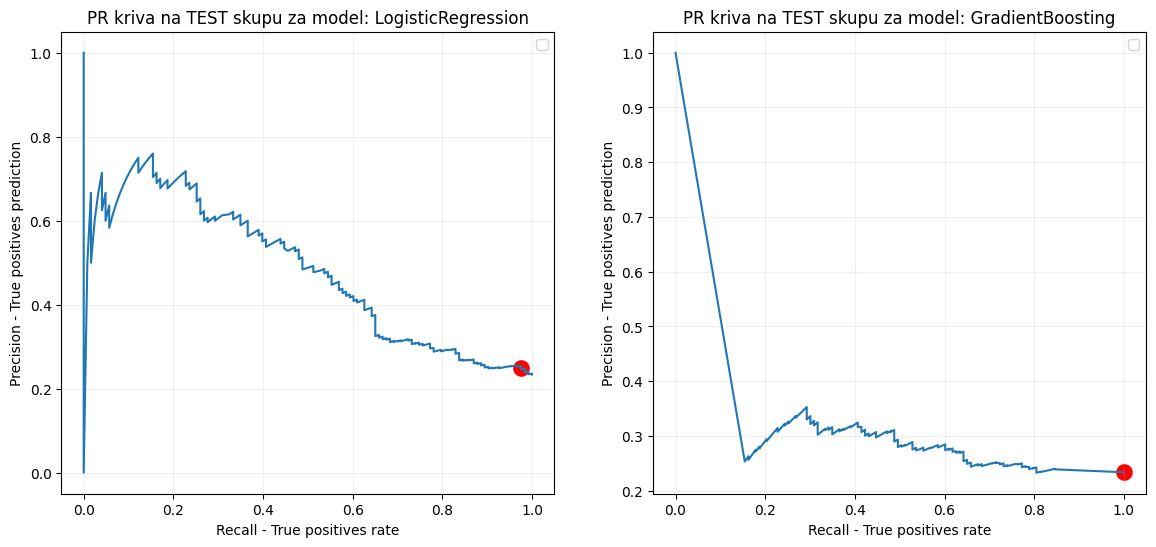

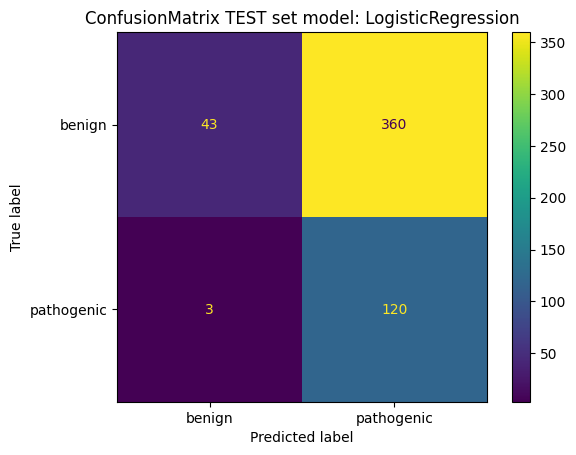

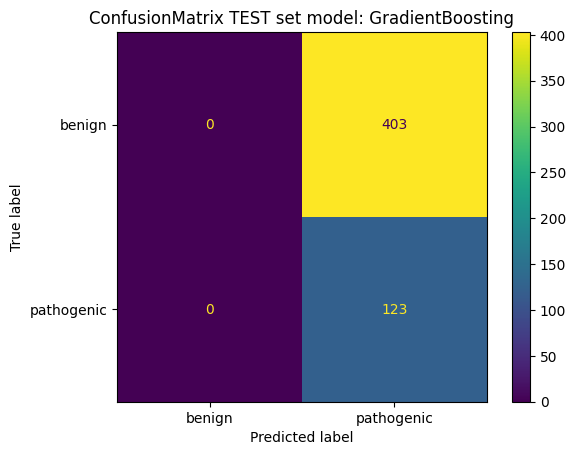

In [115]:
fig,ax=plt.subplots(1,2,figsize=(14,6))
for i,item in enumerate(thresholds_storage):
    model_name = item['model']
    best_model = item['best_estimator']
    best_threshold = item['threshold']

    #
    y_pred_proba = best_model.predict_proba(X_test)[:,1]
    
    precision,recall,threshold = precision_recall_curve(y_test,y_pred_proba)
    threshold = threshold[:-1]

    #tacka najbliza najboljem threshold-u

    idx = np.argmin(np.abs(threshold-best_threshold))

    ax[i].plot(recall,precision)
    ax[i].scatter(recall[idx],precision[idx],marker='o',color='red',s=120)
    ax[i].set_title(f"PR kriva na TEST skupu za model: {item['model']}")
    ax[i].set_ylabel('Precision - True positives prediction')
    ax[i].set_xlabel('Recall - True positives rate')
    ax[i].legend()
    ax[i].grid(alpha=.2)

    
    y_test_pred = (y_pred_proba>=best_threshold).astype(int)

    cm = confusion_matrix(y_test,y_test_pred)
    display_cm = ConfusionMatrixDisplay(cm,display_labels=['benign','pathogenic'])
    display_cm.plot()
    plt.title(f"ConfusionMatrix TEST set model: {model_name}")

## **Interpretabilnost modela**

#### GradientBoosting - __Feature importances__

#### LogisticRegression - __coef__.

---

In [116]:
"""
# posto su modeli u Pipe objektu, a pozivanje feature_importances_ direktno iz pipe-a izbacuje error:
importances_storage = []
for model in thresholds_storage:
    if 'gradientboostingclassifier' in model['best_estimator'].steps[-1]:
        feature_importances=model['best_estimator'].steps[-1][-1].feature_importances_
        feature_names=model['best_estimator'].get_feature_names_out
    else:
        feature_importances = model['best_estimator'][1].coef_
        feature_names = model['best_estimator'].feature_names_in_
    #print(model['best_estimator'].steps[1][0].feature_importances_)
    importances_storage.append({
        'model':model['model'],
        'feature_importances':feature_importances,
        'feature_names':feature_names
    })
"""

"\n# posto su modeli u Pipe objektu, a pozivanje feature_importances_ direktno iz pipe-a izbacuje error:\nimportances_storage = []\nfor model in thresholds_storage:\n    if 'gradientboostingclassifier' in model['best_estimator'].steps[-1]:\n        feature_importances=model['best_estimator'].steps[-1][-1].feature_importances_\n        feature_names=model['best_estimator'].get_feature_names_out\n    else:\n        feature_importances = model['best_estimator'][1].coef_\n        feature_names = model['best_estimator'].feature_names_in_\n    #print(model['best_estimator'].steps[1][0].feature_importances_)\n    importances_storage.append({\n        'model':model['model'],\n        'feature_importances':feature_importances,\n        'feature_names':feature_names\n    })\n"

In [117]:
### ispravna verzija koda iz prethodnog polja
importances_storage = []
for model in thresholds_storage:
    pipe = model['best_estimator']
    model_name = model['model']

    finalni_estimator = pipe.named_steps[list(pipe.named_steps.keys())[-1]]

    if model_name =="LogisticRegression":
        feature_importances = finalni_estimator.coef_.ravel()
        feature_names_out = preprocessor_linear.get_feature_names_out()
    else:
        feature_importances = finalni_estimator.feature_importances_
        feature_names_out = preprocessor_other.get_feature_names_out()

    importances_storage.append({
        'model':model_name,
        'feature_names':feature_names_out,
        'importances':feature_importances
    })

Radi lakse interpretacije, koristim relativne feature_importances tj. normalizujem, tako da najznacaniji feature bude benchamrk vrednost = 100%

In [118]:
importances_storage

[{'model': 'LogisticRegression',
  'feature_names': array(['scaler__cadd_phred', 'imputer_nans__revel',
         'imputer_nans__sift_score', 'imputer_nans__blosum62',
         'imputer_nans__alphamissense_score', 'ordinal__impact',
         'oneHot__consequence_3_prime_UTR_variant',
         'oneHot__consequence_5_prime_UTR_variant',
         'oneHot__consequence_downstream_gene_variant',
         'oneHot__consequence_intron_variant',
         'oneHot__consequence_missense_variant',
         'oneHot__consequence_splice_acceptor_variant',
         'oneHot__consequence_splice_donor_5th_base_variant',
         'oneHot__consequence_splice_donor_region_variant',
         'oneHot__consequence_splice_donor_variant',
         'oneHot__consequence_splice_polypyrimidine_tract_variant',
         'oneHot__consequence_splice_region_variant',
         'oneHot__consequence_stop_gained', 'oneHot__consequence_stop_lost',
         'oneHot__consequence_synonymous_variant'], dtype=object),
  'importances'

In [119]:
# 2 razlicita DataFrame-a , za LogReg i GB odvojeno
for item in importances_storage:
    features = item['feature_names']
    importances = item['importances']
    if item['model'] == "GradientBoosting":
        df_gb = (pd.DataFrame({'feature':features,'importances':importances})
        .assign(importances_norm=lambda row: (row['importances']/row['importances'].max())*100).sort_values(by='importances_norm',ascending=False))#row wise normalizacija
    else:
        df_logreg = ((pd.DataFrame({
            'feature':features,
            'coef':importances
        })).assign(coef_abs = lambda x:x['coef'].abs())
        .assign(coef_odds = lambda y: y['coef_abs']/y['coef_abs'].max()*100)
        .assign(odds_ratio = lambda z: np.exp(z['coef']))
        .sort_values(by='coef_odds',ascending=False))


In [120]:
df_logreg

,feature,coef,coef_abs,coef_odds,odds_ratio
0,scaler__cadd_phred,0.613885,0.613885,100.000000,1.847596
4,imputer_nans__alphamissense_score,0.399861,0.399861,65.136098,1.491617
10,oneHot__consequence_missense_variant,0.376386,0.376386,61.312172,1.457010
1,imputer_nans__revel,0.224472,0.224472,36.565726,1.251661
19,oneHot__consequence_synonymous_variant,-0.197790,0.197790,32.219322,0.820542
9,oneHot__consequence_intron_variant,-0.119935,0.119935,19.536977,0.886978
15,oneHot__consequence_splice_polypyrimidine_trac...,-0.103126,0.103126,16.798830,0.902014
2,imputer_nans__sift_score,-0.090114,0.090114,14.679253,0.913827
3,imputer_nans__blosum62,-0.056461,0.056461,9.197314,0.945103
5,ordinal__impact,-0.043356,0.043356,7.062523,0.957571


In [121]:
df_gb

,feature,importances,importances_norm
19,remainder__cadd_phred,0.504449,100.000000
18,oneHot__consequence_synonymous_variant,0.185299,36.733052
0,imputer_nans__revel,0.071529,14.179629
8,oneHot__consequence_intron_variant,0.071443,14.162545
4,ordinal__impact,0.040617,8.051775
3,imputer_nans__alphamissense_score,0.036713,7.277941
13,oneHot__consequence_splice_donor_variant,0.032804,6.503020
2,imputer_nans__blosum62,0.029088,5.766209
1,imputer_nans__sift_score,0.009473,1.877908
10,oneHot__consequence_splice_acceptor_variant,0.004734,0.938521


Plotujem vrednosti koeficijenata/feature_importances na barh plotu.
Posle nekoliko neuspelih pokusaja da plotujem barh plot, jer sam uporno parametar **width** koristio za debiljinu barova, pri cemu ovaj parametar zapravo ima veze sa duzinom bar-a, dok je parametar **height** odgovoran za debljinu barova. 

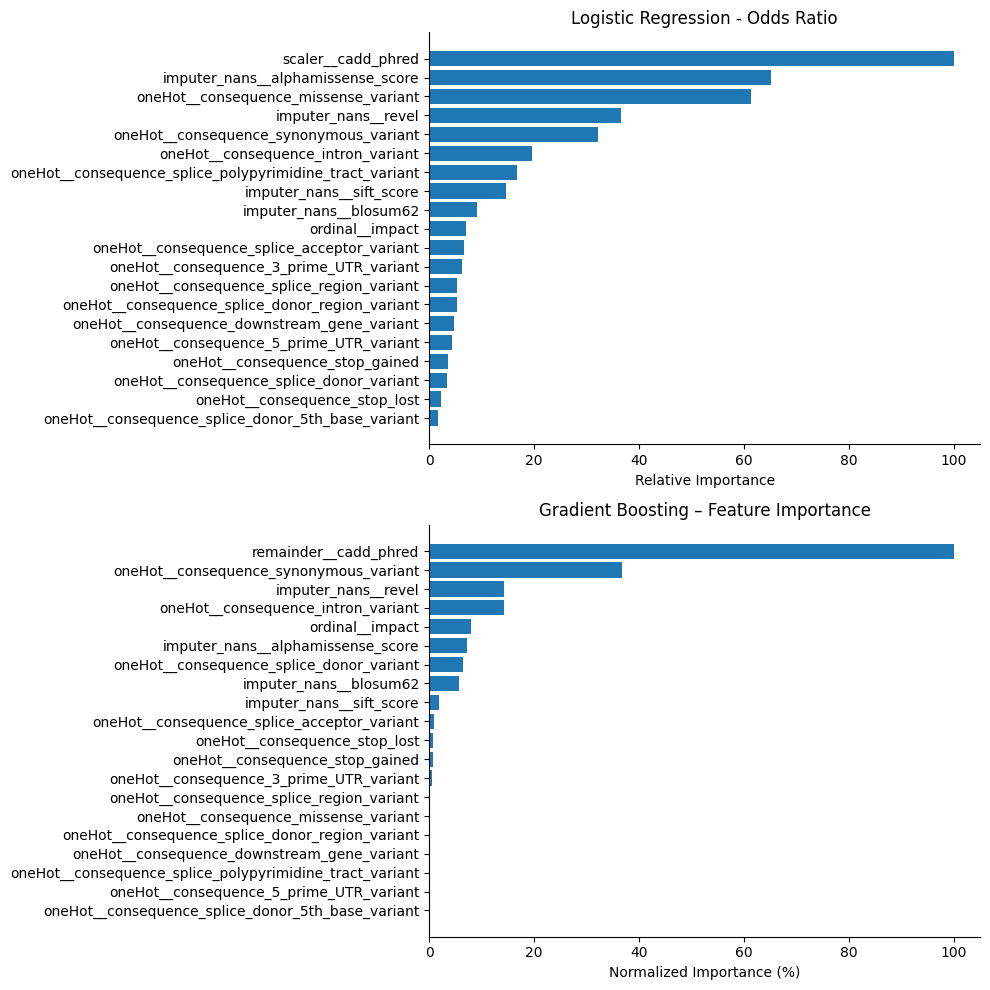

In [122]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=False)


df_lr = df_logreg.sort_values('coef_odds')
y_pos_lr = range(len(df_lr))

ax[0].barh(
    y=y_pos_lr,
    width=df_lr['coef_odds'],
    align='center'
)

ax[0].set_yticks(y_pos_lr)
ax[0].set_yticklabels(df_lr['feature'])
ax[0].set_title('Logistic Regression - Odds Ratio')
ax[0].set_xlabel('Relative Importance')

df_gb_sorted = df_gb.sort_values('importances_norm')
y_pos_gb = range(len(df_gb_sorted))

ax[1].barh(
    y=y_pos_gb,
    width=df_gb_sorted['importances_norm'],
    align='center'
)

ax[1].set_yticks(y_pos_gb)
ax[1].set_yticklabels(df_gb_sorted['feature'])
ax[1].set_title('Gradient Boosting – Feature Importance')
ax[1].set_xlabel('Normalized Importance (%)')

sns.despine()
plt.tight_layout()
plt.show()


## __Diskusija__

---

### _Logisticka Regresija_

Logisticka regresija se koristi za probleme klasifikacije i zasniva se na linearnoj kombinaciji ulaznih promenljivih i koristi istu formulu kao Linearna Regresija. Koriscenje Linearne regresije za klasifikacioni problem nije pogodno jer njen output nije ogranicen na interval [0,1], vec daje realne vrednosti koje se ne mogu interpretirati kao verovatnoce klasa. Linearna regresija fituje 'ravan' tako da minimizira udaljenost izmedju te tacke i ravni (u slucaju 1 feature-a). 
Sa obzirom da predikcije nisu verovatnoce, ne postoji __threshold__ odnosno granicna vrednost koja bi sluzila za razdvajanje klasa.

**Logisticka Regresija** koristi __logit (sigmoid)__ funkciju koja linearni izraz stavlja u interval [0,1], pri cemu ovde output postaje interpretabilan kao __verovatnoca__.
 
&emsp;f(x) = 1 / 1+ exp-(x); sigmoid -> sigma(z) = 1 / 1+e-z, z = β_0 + β1x1+...βnXn

Dalje, model se moze zapisati u obliku odnosa verovatnoca:

&emsp;P(x)/ 1 - P(x) = e^β0 + β1X1+..+βnXn 

Leva strana jednacine naziva se __odds__ i moze imati bilo koju vrednost izmedju 0 i np.inf(). Logaritmovanjem obe strane jednacine dobija se linearna veza:

&emsp;log(P(X)/1-P(x)) =β0 + β1X1+..+βnXn  

Parametar __β__ određuje stopu rasta ili opadanja S-krive. Znak β ukazuje na to da li je kriva 
opadajuća ili rastuća, kao i na stopu rasta promene kako |β| raste.

__Ukoliko dodje do povecanja _Xj_ za jedinicu, odds se menja za faktor exp(_βj_)__

### **Interpretacija koeficijenata modela**

Koeficijenti Logisticke Regresije prikazani su u DataFrame-u (df_logreg). Dodatno napravljena je kolona sa apsolutnim vrednostima koeficijenata kao i normalizovana kolona, ladi lakse vizuelne interpretacije. Velicina koeficijenata prikazuje jacinu i smer uticaja tog feature-a na promenu verovatnoca za pozitivnu klasu, uz pretpostavku da su ostali feature-i konstantni. U sledecem delu opisacu iskljucivo coef. kolonu, dok je relativna znacajnost prikazana na plot-u.

#### **1. cadd_phred**

Najjaci pozitivni efekat ima feature __cadd_phred__ i koeficijent iznosi 0.61. Ovaj feature znacajno utice na patogenost varijante i to ako posmaramo kroz formulu odds:

&emsp;P(X)/1-P(X) = e(0.61)

&emsp;odds = 1.84

Povecanje __cadd_phred__ skora za 1 jedinicu povecava patogenost varijante za faktor 1.84 (~84%) uz konstantnost ostalih nezavisnih promenljivih.

#### **2. alphamissense_scoer**

Drugi najjaci pozitivni efekat ima __alphamissense_score__ i koeficijent iznosi ~ 0.39. Povecanje ovog skora pokazuje da je veca verovatnoca da je missense varijanta patogena. Za razliku od LogistickeRegresije gde ovaj skor pokazuje jak pozitivan efekat, kod GradientBoosting modela, ovaj scor pokazuje zanemarljiv pozitivni efekat.
Posto je __alphamissense_score__ definisan samo za missense varijante, očekivano je da sama cinjenica da je varijanta missense nosi pozitivan signal u modelu.

#### **3. missense_variant** 

Odmah iza prethodnog skora, koeficijen ovog feature-a iznosi 0.38. Kategorija missense_variant pokazuje pozitivan koeficijent u modelu, jer nosi osnovnu informaciju o strukturnoj promeni proteina.


#### **4. revel**

revel predstavlja kombinovani prediktor patogenosti ciji koeficijent pokazuje umereni pozitivan efekat  ~ 0.22%. Kao i __alphamissense_score__, revel je iskljucivo vezan za kategoriju missense varijanti. Sa obzirom na velicinu dataset-a, kao i da 50% varijanata nisu missense, ocekivan je bias za velicinu koeficijenta. 

#### **5. sift_score & blosum62** 

Koeficijent ovih skorova imaju negativan znak sto implicira da smanjuju odds. __sift_score__ je obrnuto skaliran sto znaci da veca vrednost  = tolerantiji efekat 

---

## _GradientBoosting_

GradientBoosting predstavlja ansambl algoritam koji se koristi i za regresione i klasifikacione zadatke i sastoji se od veceg broja __Decision Tree__. Algoritam  zapocinje sa inicijalnim modelom, jednostavnim poput jednog Decision Tree-a, sa jednim cvorom, koji vrsi inicijalnu predikciju.
U svakoj iteraciji, vrsi se proracun greske prethodnih modela. Za razliku od Logisticke Regresije, GradientBoosting ne predstavlja linearnu vezu izmedju ulaznih promenljivih i target promenljive i ne zahteva transformaciju funckije poput Logit transformacije kod LogReg. GB ne zahteva skaliranje podataka i normalizaciju kao sto je slucaj kod linearnih modela.

Model u osnovnom obliku:


&emsp;Fm(x) = SUM(gama_m,h_m)*(x)


- M - broj stabala
- h_m - tzv. weak learner (plitak decision tree)
- gama_m - learning rate tj. stopa ucenja (jedan od najbitnijih hiperparametara GB-a)

Kod binarne klasifikacije, model koristi Log-loss kao Loss funkciju tj. __Cross-Entropy__. Finalni output modela je zatim realna vrednost koja se nalazi u intervalu [0,1] i to uz pomoc sigmoid funkcije.

&emsp;sigma(Fm(x)) = 1 / 1+ e^-Fm(x) - > U ovom koraku se dobijaju verovatnoce klasa

GradientBoosting za razliku od Logisticke Regresije nema jednostavnu matematicku interpretaciju:

__Ukoliko se poveca Xj; odds se menja za exp(βj)__

### **Interpretacija znacajnosti promenljivih**

Kod GB algoritma znacaj feature-a se najcesce racuna kao ukupno smanjenje entropije/gini indeksa. Interpretacija rezultata prikazana je u DataFrame-u df_gb.
Feature importances kvatifikuju doprinos feature-a u ukupnoj predikciji modela.

#### **1. cad_phred**

Ovaj skor predstavlja najznacajniji feature u predikciji ciljne klse. Model se znacajno oslanja na __cadd_phred__ prilikom razlikovanja binarnih klasa. Takodje visoka vrednost pokazuje jaku vezu za pozitivnom klasom sto je bioloski i literaturno tacno, jer __cadd_phred__ predstavlja nazjacajniji prediktor patogenosti varijanata.

#### **2. synonymous_variant** 
Drugi najznacajniji feature za ovaj model je __synonymous_variant__.

Efekat sinonimnih varijanti u smislu patogenosti varijante, smatra se minminalnim. Medjutim odredjeni broj ovih sinonimnih varijanti su detekntovane u prisustvu razlicith bolesti kod ljudi (pulmonarna oboljenja,kancer itd.)(Sauna and Kimchi-Sarfaty, 2011). Iako je efekat u bioloskom smislu negativan, GB model cesto koristi ovu informaciju za razdvajanje klasa.

#### **3 i 4. revel i intron_variant** 

REVEL je ensemble patogenosti skor, pa je njegov značaj u skladu sa literaturom, dok intron varijante cesto nose nizi rizik. Model koristi intron varijante za razdvajanje sigurnih slucajeva od potencijalno patogenih.



---

In [123]:
complete_dataset['consequence'].value_counts()

consequence
missense_variant                       1376
synonymous_variant                      461
intron_variant                          283
splice_region_variant                   119
splice_polypyrimidine_tract_variant      89
stop_gained                              89
splice_donor_variant                     43
3_prime_UTR_variant                      38
splice_acceptor_variant                  38
splice_donor_region_variant              31
downstream_gene_variant                  21
splice_donor_5th_base_variant            19
5_prime_UTR_variant                      16
stop_lost                                 7
Name: count, dtype: int64

## **Zakljucak**
---

Trening podaci predstavljaju jedan od najznacajnijih delova uspesnog postavljanja modela masinskog ucenja. U ovom projektu, ulazni podaci su pazljivo obradjeni kroz razlicite metode imputacije kako bi se prevazisao problem nedostajucih vrednosti, sto je omogucilo ispravno i stabilno treniranje modela. Tokom incijalne faze, testirani su osnovni modeli od kojih su __Logisticka regresija__ i __Gradient Boosting__ algoritmi pokazali najbolje performanse. Daljom optimizacijom hiperparametara ovih modela, postignuto je dodatno poboljsanje najznacajnijih metrika koje su kljucne za  nebalansirani dataset, pre svega: **recall**, **precision** i **f1_score**

Metrika tacnosti (**accuracy**) nije smatrana znacajnom u ovom datasetu. To je pokazano u pocetnom koraku modeliranja pri cemu nasumicni __Dummy Classifier__ ostvaruje tacnost iznad ~70% predvidjajuci samo vecinsku klasu (benign, klasa 0). 

Na osnovu evaluacije na test skupu i analize matrice konfuzije,smatram da je Logisticka Regresija u ovom kontekstu bolji Model za binarnu klasifikaciju patogenih varijanti na datasetu. Model postize recall vrednost cak od 0.975, pri cemu se za ovakav dijagnosticki problem 0.95 smatra kao jako dobar recall skor. Pored toga, model pokazuje znatno bolji balans izmedju pozitivne i negativne klase (3 FN uzorka, i 120 TP na test setu).

GradientBoosting model pokazao je tendenciju ka preteranom favorizovanju pozitivne klase, klasifikujuci sve kao pozitivnu klasu sto u praksi nije pozeljno zbog velikog broja lazno pozitivnih rezultata.

U ovom projektu __target__ promenljiva, konstruisana je na osnovu klinicke znacajnosti varijanti:

Likely benign/Benign -> klasa 0 (benigna)

likely pathogenic/pathogenic - > klasa 1 (patogena)

Varijante oznacene kao __VUS__ (conflicting interpretations ili sa slabim nivoom dokaza) mapirane su na vrednost -1 i izostavljene iz trening skupa, jer nemaju pouzdanu klinicku interpretaciju. 

Dalja primena istreniranog modela na pouzdanim varijantama, mogla bi biti u svrhu procene potencijalnog klinickog znacaja __VUS__ varijanti, cime bi se model mogao koristiti kao pomocni alat u procesu prioritizacije varijanti za dalju analizu.

Smatram da je velicina dataset-a, kao i visok procenat nedostajućih vrednosti u pojedinim anotacijama jedno od glavnih ogranicenja ovog projekta.Ovakva struktura podataka sigurno znacajno utice na stabilnost modela i dovodi do gubitka znacajne informacije za ucenje modela tokom imputacija. Kao potencijalno resenje, pogodno bi bilo prikupljanje znatno veceg broja varijanti, njihova pazljiva selekcija i dodavanje veceg broja bioloskih anotacija (feature-a) sto bi uticalo na bolju generalizaciju modela na _unseen_ podacima. U tom slucaju, slozeni model kao sto je RandomForest algoritam, verovatno bi pokazao znatno bolje performanse. 

---